
SixHumpCamel: 2D


In [1]:
pip install pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SixHumpCamel'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - SixHumpCamel(x) 2-D:

def objfunc(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    
# Constraints:
lb_x1 = -3
ub_x1 = +3
    
lb_x2 = -2
ub_x2 = +2

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_global_orig = -1.0316 # targets global minimum

# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test) 
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1653139086.510705

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.192097   -0.31431616]	 2.4186042018626357	 -0.2650082867644827	 1.337802690980723	 1.5097989872197761
2  	 [-0.22547554  1.70883974]	 22.240851271072867	 -0.2650082867644827	 0.7034164352894718	 0.7046348275526473
3  	 [ 2.48831905 -1.70549005]	 41.34681451869188	 -0.2650082867644827	 0.672368280489878	 0.6723744497018823
4  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 0.672336059189003	 0.672336059189003
5  	 [-3.  2.]	 150.89999999999998	 -0.265008286764

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.394315  -0.0855252]	 0.5771015970404381	 0.011939608840498828	 0.9015116149014366	 0.9065687485421096
2  	 [ 1.8520447  -0.19662581]	 1.9521791631078012	 0.011939608840498828	 0.8038894961084159	 0.8038997384080319
3  	 [0.7387646 2.       ]	 51.089287775511956	 0.011939608840498828	 0.8038570933644301	 0.8038430889973723
4  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 0.8035235723738927	 0.8036906030777401
5  	 [-3.  2.]	 150.89999999999998	 0.011

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.23091653  0.29148198]	 -0.1709115750473108	 -0.2431922946563294	 0.9345840987136211	 0.9349100345272257
2	 [-0.39661824  0.85835815]	 -0.5376271123093992	 -0.5376271123093992	 0.7744005504201765	 0.7838215829542815
3  	 [-0.20567507  0.24083052]	 -0.1025982343756329	 -0.5376271123093992	 0.6198401964559045	 0.6200783424909797
4  	 [-0.53334412  1.38957084]	 7.424435413635118	 -0.5376271123093992	 0.5961150085172686	 0.604866178159365
5  	 [ 0.02178278 -0.23983167]	 -0

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [ 0.13819594 -1.09159236]	 0.8378729774634637	 0.8378729774634637	 2.801662033633455	 3.791692141333517
2	 [ 0.16279962 -1.07402785]	 0.6381308545553743	 0.6381308545553743	 1.2320345668948194	 1.490815384247802
3  	 [-3.  2.]	 150.89999999999998	 0.6381308545553743	 1.1069909101449493	 1.1409868583709715
4  	 [-3. -2.]	 162.89999999999998	 0.6381308545553743	 1.1311536638599904	 1.1311536638599904
5	 [-0.2684865  -0.13256571]	 0.24408549849400593	 0.24408549849400593	 1.38422984

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.32583962 1.00818382]	 0.7967378648901146	 -0.6512780061070701	 0.5212081552885773	 0.5234080916834288
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 0.5123706806686489	 0.5131927046513921
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.5086202638129996	 0.5086202638129996
4  	 [0.42541128 0.03130576]	 0.6664973415818584	 -0.6512780061070701	 0.47558784876109245	 0.48874864677359475
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 0.4233987600

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.19888425 0.9100373 ]	 -0.2332764812394369	 -0.3096187466378422	 0.7490117988921283	 0.7522208865862203
2	 [0.11616358 0.67403978]	 -0.8597636401944564	 -0.8597636401944564	 0.6497122309538157	 0.6621932615483833
3  	 [0.13061592 0.70536898]	 -0.8402109801710181	 -0.8597636401944564	 0.45441706381655145	 0.4609708224163075
4  	 [0.13127647 0.70691009]	 -0.8388869631784943	 -0.8597636401944564	 0.47953424419222995	 0.48037829202265125
5  	 [0.13174678 0.70800777]	 

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.14003009 1.65200862]	 19.18508624211387	 -0.46481072558790276	 0.6285322469996836	 0.628558601149586
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016	 0.5869305043864016
3  	 [-0.4710912   0.58002584]	 -0.3783016258138169	 -0.46481072558790276	 0.6492280170905194	 0.6533646925660255
4	 [-0.14196841  0.42856787]	 -0.5808157077649232	 -0.5808157077649232	 0.6271207488660728	 0.6206254438218206
5  	 [-0.35209353  0.

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1  	 [-0.77086852  0.8427215 ]	 0.23242280862807874	 0.03190064766213015	 0.9022574499586161	 0.915238834117423
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 0.7897643681259767	 0.8081807736676027
3	 [-0.24360316  0.39126531]	 -0.3838787921564339	 -0.3838787921564339	 0.9747247954632011	 0.9759771223415733
4  	 [-0.24416382  0.38712363]	 -0.3730717141618553	 -0.3838787921564339	 0.6859391775604474	 0.6866327865573438
5  	 [-0.24497382  0.3815139 ]	 -0.358372137383661

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.19940424 1.29253387]	 4.895113429317262	 1.395407492769129	 1.682291546912281	 1.682555472693601
2  	 [ 3.         -0.21530597]	 108.07725120876724	 1.395407492769129	 1.6817122935056026	 1.6820246334673141
3  	 [-1.44918933  2.        ]	 47.32755997246911	 1.395407492769129	 1.4707212379894836	 1.5059958162200322
4  	 [-1.57485547 -2.        ]	 53.23815652676946	 1.395407492769129	 1.0433550343640943	 1.043355203994845
5	 [-0.51194155 -0.15335819]	 0.8967402786610343	 0.8967402

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.2427373691564543	 1.2427373691564543
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 1.153407623100308	 1.2003547366973941
3  	 [ 3.         -0.56605295]	 106.33084286552443	 0.7775687473184012	 1.2462221349728737	 1.2462221349744769
4	 [-0.75325616  0.62545312]	 0.2306309503126016	 0.2306309503126016	 4.023651634004785	 4.7026024272490465
5  	 [-0.77425418  0.62943652]	 0.2707854549208578	 0.2306309503126016	 2.24812

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.79052499 -2.        ]	 46.642439884823425	 -0.6254688257880329	 0.4979421281625386	 0.5012187568587185
2  	 [-0.41855109  2.        ]	 47.80098145434491	 -0.6254688257880329	 0.4729276448300367	 0.4990340158985407
3  	 [ 0.09051384 -0.00503657]	 0.03207290245357713	 -0.6254688257880329	 0.5875620176752806	 0.5878058026335047
4  	 [ 0.08003264 -0.00212968]	 0.025346239213521134	 -0.6254688257880329	 0.4538248115364662	 0.4792253139447395
5  	 [ 0.07460422 -0.0005854 

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.33787814  0.82388558]	 0.3687967316016376	 0.3687967316016376	 2.435731594709521	 2.607886882019929
2  	 [1.74532509 2.        ]	 53.61106448560614	 0.3687967316016376	 0.9958060636574879	 0.9958060426591716
3  	 [-3. -2.]	 162.89999999999998	 0.3687967316016376	 0.9956541467104483	 0.9956541467104483
4  	 [-0.16291724 -2.        ]	 48.43052940735004	 0.3687967316016376	 0.9882969793819566	 0.9882972751221214
5	 [-1.49393262  0.64566325]	 0.23576921269866558	 0.2357692126

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.69815135 -1.55842173]	 14.28054111674823	 0.752930921147986	 2.6187640905685425	 2.685632012966149
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 1.230232077003061	 1.230232181671132
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2302321776788392	 1.2302321776788392
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 1.2302321819970747	 1.2302321819970747
5	 [-0.19817058  0.59883807]	 -0.8848364384885529	 -0.8848364384885529	 1.2180884171697015	 1.2

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
5  	 [ 0.10283645 -0.51837155]	 -0.7972586

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.31230959  1.23090923]	 3.1080722159018226	 2.1163170846379233	 2.2680470204698286	 2.2682349484022084
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 2.26527327157247	 2.26527327157247
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 2.237969084442202	 2.2467674012643
4	 [-0.27070753 -0.29551242]	 0.04317525210954243	 0.04317525210954243	 2.962918899491408	 2.966951346388912
5  	 [-0.27822656 -0.29113598]	 0.0679091034762424	 0.04317525210954243	 0.941306749

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.04379577]	 108.76095511622187	 1.8632773736203017	 2.053885599583561	 2.053886214758995
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.0478994857553015	 2.0478994857553015
3  	 [0.53255513 2.        ]	 50.03825589572349	 1.8632773736203017	 2.042145348565978	 2.0421645180814587
4  	 [-0.91745518 -0.01809312]	 2.0931250544610216	 1.8632773736203017	 1.4051761877911089	 1.4854314419320847
5  	 [-1.03036573 -0.06609209]	 2.329255703316371	 1.863277373

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1	 [-0.55712461  1.08599902]	 1.2904710658119267	 1.2904710658119267	 2.250920008342742	 2.4395876955173423
2  	 [ 3. -2.]	 150.89999999999998	 1.2904710658119267	 1.5697533827113503	 1.591288214616489
3  	 [3. 2.]	 162.89999999999998	 1.2904710658119267	 1.524132087624322	 1.524132087624322
4  	 [0.92241896 0.18981451]	 2.1246076249162456	 1.2904710658119267	 1.4174388737027848	 1.4178587861502434
5  	 [-1.56013631  2.        ]	 46.981199722849475	 1.2904710658119267	 1.419545943069

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 2.199855861254636	 2.216830674405081
2	 [ 0.51933671 -0.47021346]	 -0.0004394396635983844	 -0.0004394396635983844	 1.018930227355742	 1.0229055623312582
3	 [ 0.46722721 -0.47742821]	 -0.15039947743179116	 -0.15039947743179116	 0.318140166283706	 0.3397377854186444
4	 [ 0.44976542 -0.47473191]	 -0.185850985359444	 -0.185850985359444	 0.3521743501210634	 0.36646662794497553
5	 [ 0.44009013 -0.47280308]	 -0.20399702803786712	 -0.2039970280378

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [-0.04594898  2.        ]	 47.91653792225923	 6.578088852480828	 5.89231557551927	 5.923965955295371
2  	 [ 1.66268611 -2.        ]	 46.72598915869578	 6.578088852480828	 6.2893238546896555	 6.421344404474899
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.553585234442593	 4.553585234442593
4	 [-0.30754498 -0.24340012]	 0.21175209542074475	 0.21175209542074475	 3.32397078580947	 3.3283024098563856
5	 [-0.2387471  -0.21981558]	 0.08978312210024167	 0.08978312210024167	 0.145

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.16287629 -2.        ]	 52.718971577970876	 1.5037392797834441	 1.6226897877682127	 1.622804168165917
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 1.4805438857167674	 1.6680546462583556
3	 [ 0.44491636 -0.320089  ]	 0.20184951869993123	 0.20184951869993123	 0.6723121559844599	 0.7085213323113986
4  	 [ 0.44440553 -0.31347917]	 0.21688151842989672	 0.20184951869993123	 0.136392622641521	 0.35438587774641994
5  	 [ 0.44473353 -0.31307704]	 0.21870342043828506	 0.2018

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1653140038.0599198

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.0222508  -0.56767234]	 1.973814968771222	 -0.2650082867644827	 1.337802690980723	 1.5097989872197761
2  	 [-1.26808268 -0.11971968]	 2.483320809777564	 -0.2650082867644827	 0.8119767223317924	 0.847168915509338
3  	 [-0.46825449  1.65874906]	 19.278966985258446	 -0.2650082867644827	 0.7060383194836218	 0.7101223189803031
4  	 [0.57640459 0.14873338]	 1.108587134238383	 -0.2650082867644827	 0.697339666064322	 0.6973948449929737
5  	 [3. 2.]	 162.89999999999998	 -0

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.31993916 -0.13822589]	 0.35705692889941354	 0.011939608840498828	 0.9015116149014366	 0.9065687485421096
2  	 [ 2.04712605 -0.34677951]	 3.282001189089567	 0.011939608840498828	 0.8038736054227188	 0.8038750053590975
3  	 [0.87539309 2.        ]	 51.73284557719287	 0.011939608840498828	 0.8038568874854809	 0.8038568880895053
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 0.8034960151089423	 0.8036543216438059
5  	 [3.         1.37226037]	 119.6686

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.24615147  0.33088291]	 -0.23670797327271403	 -0.2431922946563294	 0.9345840987136211	 0.9349100345272257
2	 [-0.26381472  0.43546912]	 -0.4612403653312914	 -0.4612403653312914	 0.7867728235639136	 0.7886357465077862
3  	 [-0.5179925   1.23412136]	 3.4758222002525088	 -0.4612403653312914	 0.6561891579829667	 0.657931138690044
4  	 [-0.06732346 -0.21593141]	 -0.14518548269446432	 -0.4612403653312914	 0.7615621375872988	 0.7710701340242885
5  	 [ 0.0502389  -0.29319298]	

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [-0.19248638 -0.29673967]	 -0.118746904624908	 -0.118746904624908	 2.801662033633455	 3.791692141333517
2	 [ 0.0771446 -0.9683799]	 -0.2844404270558513	 -0.2844404270558513	 1.4618491526354545	 1.5136022118717296
3  	 [ 0.15454763 -1.42856043]	 8.369638169079648	 -0.2844404270558513	 1.0080760300974796	 1.0700612874386304
4  	 [-0.59840288  1.94539575]	 42.167704564580156	 -0.2844404270558513	 0.6339682859220072	 0.6518604642507942
5  	 [-3. -2.]	 162.89999999999998	 -0.284440427

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.27873899 1.08341635]	 1.4162287546962613	 -0.6512780061070701	 0.5212081552885773	 0.5234080916834288
2  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.5110424850686868	 0.5124319383353108
3  	 [ 2.22867654 -2.        ]	 52.44845273639255	 -0.6512780061070701	 0.5135687417648415	 0.5135839819735787
4  	 [0.27494058 0.16395744]	 0.2309544090446074	 -0.6512780061070701	 0.43912733125454495	 0.44452452683417937
5  	 [-3. -2.]	 162.89999999999998	 -0.651278006107070

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.14564833 0.99656045]	 0.20177881687152865	 -0.3096187466378422	 0.7490117988921283	 0.7522208865862203
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 0.624361690543775	 0.624361690543775
3	 [-0.20642557  0.73264737]	 -0.9791695830839107	 -0.9791695830839107	 0.5720634054283468	 0.6312838037973438
4  	 [-0.1567979   0.53674031]	 -0.8074587029374714	 -0.9791695830839107	 0.4034354809521641	 0.4174490764577982
5  	 [-0.08928664  0.26902626]	 -0.2608132060388

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.13108407 1.64834671]	 18.94537335616538	 -0.46481072558790276	 0.6285322469996836	 0.628558601149586
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016	 0.5869305043864016
3  	 [-0.62752974  0.70661876]	 -0.17354655716349243	 -0.46481072558790276	 0.6492443808080399	 0.653317887985786
4	 [-0.29852863  0.52826749]	 -0.622422044148511	 -0.622422044148511	 0.623373526874398	 0.6290600667698218
5  	 [-3. -2.]	 162.8999

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579328253045	 -0.25569579328253045	 0.9022574499586161	 0.915238834117423
2  	 [-1.18831557  1.21804401]	 3.8222330710419667	 -0.25569579328253045	 0.6921018395852151	 0.6921529664120636
3  	 [0.04982841 0.04620172]	 0.003700531824410219	 -0.25569579328253045	 0.5314874765523403	 0.6135018754597285
4  	 [ 1.5233709  -1.90834873]	 37.71548823920068	 -0.25569579328253045	 0.5544341266061554	 0.6134982246048132
5	 [-0.33912575  0.43440778]	 -0

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.30007957 2.        ]	 48.943565457339844	 1.395407492769129	 1.682291546912281	 1.682555472693601
2  	 [3.         0.35932676]	 109.52820087466702	 1.395407492769129	 1.6809320556471568	 1.6820030250315097
3  	 [ 1.704465   -1.87727248]	 34.45211943995564	 1.395407492769129	 1.423933531626986	 1.5460273211106768
4  	 [-1.52265551 -2.        ]	 53.18521056446499	 1.395407492769129	 1.2222454430264156	 1.2232587556255685
5	 [-0.45353017 -0.14809988]	 0.718169771719545	 0.718169771

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.2427373691564543	 1.2427373691564543
2  	 [-2.52977022  2.        ]	 69.90104466534116	 0.7775687473184012	 1.153407623100308	 1.2003547366973941
3  	 [-0.96097071  0.29985559]	 1.5500439542561053	 0.7775687473184012	 1.2459535277677591	 1.2460948389535356
4  	 [ 3.         -0.28423055]	 107.75026649141844	 0.7775687473184012	 1.2461071777798243	 1.2461071777379487
5	 [-0.34833992  0.78170472]	 -0.7679208021692747	 -0.7679208

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [0.1162043  0.20936558]	 -0.08968928579150665	 -0.6254688257880329	 0.4979421281625386	 0.5012187568587185
2  	 [-0.26857992  1.50634431]	 11.391644241601337	 -0.6254688257880329	 0.46476682236841	 0.5008282196246693
3  	 [ 1.46188583 -1.88617587]	 35.8505521757125	 -0.6254688257880329	 0.49924493450018015	 0.5626080102176552
4  	 [ 0.19155584 -0.03220303]	 0.13365101792458087	 -0.6254688257880329	 0.1756330394634262	 0.2248271719563968
5  	 [0.05153275 0.10757978]	 -0.

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.15648614  0.74752294]	 0.5401694801069382	 0.5401694801069382	 2.435731594709521	 2.607886882019929
2  	 [1.83110354 2.        ]	 54.030148102465176	 0.5401694801069382	 1.0968899740052525	 1.0968899472812244
3  	 [-3. -2.]	 162.89999999999998	 0.5401694801069382	 1.0967323782314136	 1.115839827871094
4  	 [-0.16342278 -2.        ]	 48.432182084360264	 0.5401694801069382	 1.089019458933188	 1.089019481349252
5	 [-1.47701765  0.78295103]	 0.08738735600875491	 0.08738735600

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.4943127  -1.24330367]	 3.617106922875216	 0.752930921147986	 2.6187640905685425	 2.685632012966149
2  	 [-0.83460691  1.3144168 ]	 5.811882953645614	 0.752930921147986	 1.598822105756367	 1.8887041513365035
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2263652050001004	 1.3192139084683576
4  	 [ 1.11089436 -2.        ]	 48.14281330125023	 0.752930921147986	 1.320203587249645	 1.3335124801136937
5  	 [ 2.10322474 -1.94085306]	 43.06366123572329	 0.752930921147986	 1.23023218

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952	 0.3866284247694952
5  	 [ 0.17242098 -0.54461431]	 -0.8113556

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1	 [-0.21638195  1.08971973]	 0.8374844369105674	 0.8374844369105674	 2.2680470204698286	 2.2682349484022084
2  	 [3. 2.]	 162.89999999999998	 0.8374844369105674	 1.285559112270021	 1.285559112270021
3  	 [-1.96941763  2.        ]	 47.43343973700401	 0.8374844369105674	 1.2719127077875299	 1.2719450252386753
4  	 [-0.17804826 -2.        ]	 48.48080142953704	 0.8374844369105674	 1.2619484071543063	 1.2619484074120468
5  	 [0.70088049 0.45442228]	 1.1607610430953619	 0.837484436910

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.        -0.0316618]	 108.80100873727955	 1.8632773736203017	 2.053885599583561	 2.053886214758995
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.0478946637408733	 2.0478946637408733
3  	 [0.53458998 2.        ]	 50.04859102063811	 1.8632773736203017	 2.0418140743345012	 2.0418196996612825
4  	 [-1.1013503   0.07301338]	 2.255414821136925	 1.8632773736203017	 1.4047280082892173	 1.4858990536657077
5	 [-0.38436756 -0.0739003 ]	 0.5528717725895	 0.5528717725895	 

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [-0.94844345  1.77369891]	 27.464707626764916	 1.7722768782964888	 2.250920008342742	 2.4395876955173423
2  	 [ 2.16747806 -2.        ]	 50.670774669928775	 1.7722768782964888	 1.9472789324332946	 1.965905330546023
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.87718084296977	 1.87718084296977
4  	 [0.9795796  0.22213589]	 2.2291366143567006	 1.7722768782964888	 1.6277906008330256	 1.6289761559890918
5	 [-0.08334278 -0.32165665]	 -0.31654300371641775	 -0.316543003716417

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.66531467  1.40819618]	 45.98276516160892	 2.062169771852028	 2.199855861254636	 2.216830674405081
2  	 [3.         0.60316289]	 109.78368446093096	 2.062169771852028	 0.9295861753863687	 0.9377227304764577
3  	 [1.89592609 0.6375228 ]	 2.969704029748832	 2.062169771852028	 2.2191685332046376	 2.2191685332046376
4  	 [-0.32173714 -1.49268739]	 11.817714263649087	 2.062169771852028	 2.2191685332046376	 2.2191685332046376
5	 [-0.73927211  0.43212897]	 0.6863399819879844	 0.68633998198798

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [0.10116931 2.        ]	 48.243059900228204	 6.578088852480828	 5.89231557551927	 5.923965955295371
2  	 [ 1.41549173 -1.88944902]	 36.29075133246817	 6.578088852480828	 6.479937437058447	 6.519065755606967
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.565825257219927	 4.565825257219927
4	 [-0.26066815 -0.13998386]	 0.22184393346320744	 0.22184393346320744	 3.7962017639103958	 3.7989530688135194
5	 [ 0.19813132 -0.17803828]	 -0.0042384383196845815	 -0.0042384383196845815	

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.18115566 -2.        ]	 52.76057163057528	 1.5037392797834441	 1.6226897877682127	 1.622804168165917
2  	 [ 2.59213852 -1.65326133]	 47.84960809826183	 1.5037392797834441	 1.4750079879150166	 1.6656579209007742
3	 [ 0.22139217 -0.162917  ]	 0.05163369461120049	 0.05163369461120049	 0.4690237988202402	 0.46905844375831135
4	 [-0.33967677  0.28979802]	 0.02792003913677127	 0.02792003913677127	 0.09328850938049889	 0.23297857586610754
5	 [ 0.04615974 -0.02633357]	 0.004525901400

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


914.0005352497101

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.03345393546715016, -0.09153418201768146)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-0.7052746465177605, -1.5615035683527487)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-5.073459014245215, -1.5236556203622285)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-1.846777855732862, -2.4165809968206173)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.7612126515129705, -2.948268380567984)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-0.79676634162262, -0.8936051176864497)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-0.4342949100167238, -1.666791637500239)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-0.034893988086866404, -2.122371797588949)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.23288075079321421, -1.7159672858412292)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.9010790823704407, -1.114233240672264)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.2369432659116363, 0.11242412989933243)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-1.9189324121999258, -3.0989256767843743)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-6.074727392833108, -6.074727392833108)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.07211157191682917, 0.04583599271443615)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.039478812853904, 0.021253054625855344)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-0.0555244807687164, -3.7104869471445148)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-0.25645293451185736, -0.531464490583476)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-0.022991906972496465, -0.025434663973698018)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(0.20981473089641342, -0.07875553303873715)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

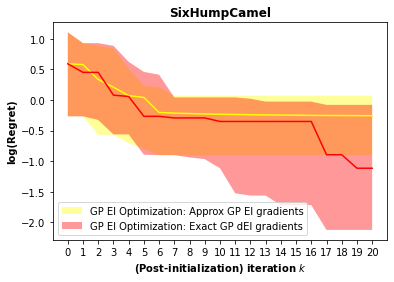

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(951.5491116046906, 914.0005352497101)

In [100]:
min_ei = 0


In [101]:
### acqFunc regret minimization: run number = 1

### Exact
acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history) 
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

acqFuncApproxRegret_exact_1 = np.log(acqFuncApprox_exact_1 - min_ei)
acqFuncExactRegret_exact_1 = np.log(acqFuncExact_exact_1 - min_ei)

acqFuncApproxSimpleRegret_exact_1 = min_max_array(acqFuncApproxRegret_exact_1)
acqFuncExactSimpleRegret_exact_1 = min_max_array(acqFuncExactRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1 = min(acqFuncApproxSimpleRegret_exact_1)
min_acqFuncExactSimpleRegret_exact_1 = min(acqFuncExactSimpleRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1, min_acqFuncExactSimpleRegret_exact_1


(-1.1476890175965984, -2.25062078650499)

In [102]:
### acqFunc regret minimization: run number = 2

### Exact
acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history) 
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

acqFuncApproxRegret_exact_2 = np.log(acqFuncApprox_exact_2 - min_ei)
acqFuncExactRegret_exact_2 = np.log(acqFuncExact_exact_2 - min_ei)

acqFuncApproxSimpleRegret_exact_2 = min_max_array(acqFuncApproxRegret_exact_2)
acqFuncExactSimpleRegret_exact_2 = min_max_array(acqFuncExactRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2 = min(acqFuncApproxSimpleRegret_exact_2)
min_acqFuncExactSimpleRegret_exact_2 = min(acqFuncExactSimpleRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2, min_acqFuncExactSimpleRegret_exact_2


(-1.042828237318188, -1.573280881820209)

In [103]:
### acqFunc regret minimization: run number = 3

### Exact
acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history) 
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

acqFuncApproxRegret_exact_3 = np.log(acqFuncApprox_exact_3 - min_ei)
acqFuncExactRegret_exact_3 = np.log(acqFuncExact_exact_3 - min_ei)

acqFuncApproxSimpleRegret_exact_3 = min_max_array(acqFuncApproxRegret_exact_3)
acqFuncExactSimpleRegret_exact_3 = min_max_array(acqFuncExactRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3 = min(acqFuncApproxSimpleRegret_exact_3)
min_acqFuncExactSimpleRegret_exact_3 = min(acqFuncExactSimpleRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3, min_acqFuncExactSimpleRegret_exact_3


(-0.977785096160149, -1.0179109070015948)

In [104]:
### acqFunc regret minimization: run number = 4

### Exact
acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history) 
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

acqFuncApproxRegret_exact_4 = np.log(acqFuncApprox_exact_4 - min_ei)
acqFuncExactRegret_exact_4 = np.log(acqFuncExact_exact_4 - min_ei)

acqFuncApproxSimpleRegret_exact_4 = min_max_array(acqFuncApproxRegret_exact_4)
acqFuncExactSimpleRegret_exact_4 = min_max_array(acqFuncExactRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4 = min(acqFuncApproxSimpleRegret_exact_4)
min_acqFuncExactSimpleRegret_exact_4 = min(acqFuncExactSimpleRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4, min_acqFuncExactSimpleRegret_exact_4


(-1.0187985572518385, -2.362038989569177)

In [105]:
### acqFunc regret minimization: run number = 5

### Exact
acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history) 
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

acqFuncApproxRegret_exact_5 = np.log(acqFuncApprox_exact_5 - min_ei)
acqFuncExactRegret_exact_5 = np.log(acqFuncExact_exact_5 - min_ei)

acqFuncApproxSimpleRegret_exact_5 = min_max_array(acqFuncApproxRegret_exact_5)
acqFuncExactSimpleRegret_exact_5 = min_max_array(acqFuncExactRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5 = min(acqFuncApproxSimpleRegret_exact_5)
min_acqFuncExactSimpleRegret_exact_5 = min(acqFuncExactSimpleRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5, min_acqFuncExactSimpleRegret_exact_5


(-1.1545113048471172, -1.202836992709126)

In [106]:
### acqFunc regret minimization: run number = 6

### Exact
acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history) 
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

acqFuncApproxRegret_exact_6 = np.log(acqFuncApprox_exact_6 - min_ei)
acqFuncExactRegret_exact_6 = np.log(acqFuncExact_exact_6 - min_ei)

acqFuncApproxSimpleRegret_exact_6 = min_max_array(acqFuncApproxRegret_exact_6)
acqFuncExactSimpleRegret_exact_6 = min_max_array(acqFuncExactRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6 = min(acqFuncApproxSimpleRegret_exact_6)
min_acqFuncExactSimpleRegret_exact_6 = min(acqFuncExactSimpleRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6, min_acqFuncExactSimpleRegret_exact_6


(-0.9530914118220819, -1.8902162303343055)

In [107]:
### acqFunc regret minimization: run number = 7

### Exact
acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history) 
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

acqFuncApproxRegret_exact_7 = np.log(acqFuncApprox_exact_7 - min_ei)
acqFuncExactRegret_exact_7 = np.log(acqFuncExact_exact_7 - min_ei)

acqFuncApproxSimpleRegret_exact_7 = min_max_array(acqFuncApproxRegret_exact_7)
acqFuncExactSimpleRegret_exact_7 = min_max_array(acqFuncExactRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7 = min(acqFuncApproxSimpleRegret_exact_7)
min_acqFuncExactSimpleRegret_exact_7 = min(acqFuncExactSimpleRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7, min_acqFuncExactSimpleRegret_exact_7


(-1.8136335755092317, -3.245647847200344)

In [108]:
### acqFunc regret minimization: run number = 8

### Exact
acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history) 
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

acqFuncApproxRegret_exact_8 = np.log(acqFuncApprox_exact_8 - min_ei)
acqFuncExactRegret_exact_8 = np.log(acqFuncExact_exact_8 - min_ei)

acqFuncApproxSimpleRegret_exact_8 = min_max_array(acqFuncApproxRegret_exact_8)
acqFuncExactSimpleRegret_exact_8 = min_max_array(acqFuncExactRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8 = min(acqFuncApproxSimpleRegret_exact_8)
min_acqFuncExactSimpleRegret_exact_8 = min(acqFuncExactSimpleRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8, min_acqFuncExactSimpleRegret_exact_8


(-0.9064110096857029, -0.9174955677502776)

In [109]:
### acqFunc regret minimization: run number = 9

### Exact
acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history) 
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

acqFuncApproxRegret_exact_9 = np.log(acqFuncApprox_exact_9 - min_ei)
acqFuncExactRegret_exact_9 = np.log(acqFuncExact_exact_9 - min_ei)

acqFuncApproxSimpleRegret_exact_9 = min_max_array(acqFuncApproxRegret_exact_9)
acqFuncExactSimpleRegret_exact_9 = min_max_array(acqFuncExactRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9 = min(acqFuncApproxSimpleRegret_exact_9)
min_acqFuncExactSimpleRegret_exact_9 = min(acqFuncExactSimpleRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9, min_acqFuncExactSimpleRegret_exact_9


(-1.5448038258533665, -6.992658414021255)

In [110]:
### acqFunc regret minimization: run number = 10

### Exact
acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history) 
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

acqFuncApproxRegret_exact_10 = np.log(acqFuncApprox_exact_10 - min_ei)
acqFuncExactRegret_exact_10 = np.log(acqFuncExact_exact_10 - min_ei)

acqFuncApproxSimpleRegret_exact_10 = min_max_array(acqFuncApproxRegret_exact_10)
acqFuncExactSimpleRegret_exact_10 = min_max_array(acqFuncExactRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10 = min(acqFuncApproxSimpleRegret_exact_10)
min_acqFuncExactSimpleRegret_exact_10 = min(acqFuncExactSimpleRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10, min_acqFuncExactSimpleRegret_exact_10


(-1.1716325744805884, -2.1518298426196383)

In [111]:
### acqFunc regret minimization: run number = 11

### Exact
acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history) 
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

acqFuncApproxRegret_exact_11 = np.log(acqFuncApprox_exact_11 - min_ei)
acqFuncExactRegret_exact_11 = np.log(acqFuncExact_exact_11 - min_ei)

acqFuncApproxSimpleRegret_exact_11 = min_max_array(acqFuncApproxRegret_exact_11)
acqFuncExactSimpleRegret_exact_11 = min_max_array(acqFuncExactRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11 = min(acqFuncApproxSimpleRegret_exact_11)
min_acqFuncExactSimpleRegret_exact_11 = min(acqFuncExactSimpleRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11, min_acqFuncExactSimpleRegret_exact_11


(-1.492423296574839, -2.958309963699265)

In [112]:
### acqFunc regret minimization: run number = 12

### Exact
acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history) 
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

acqFuncApproxRegret_exact_12 = np.log(acqFuncApprox_exact_12 - min_ei)
acqFuncExactRegret_exact_12 = np.log(acqFuncExact_exact_12 - min_ei)

acqFuncApproxSimpleRegret_exact_12 = min_max_array(acqFuncApproxRegret_exact_12)
acqFuncExactSimpleRegret_exact_12 = min_max_array(acqFuncExactRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12 = min(acqFuncApproxSimpleRegret_exact_12)
min_acqFuncExactSimpleRegret_exact_12 = min(acqFuncExactSimpleRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12, min_acqFuncExactSimpleRegret_exact_12


(-0.9736398420084625, -7.087123673582308)

In [113]:
### acqFunc regret minimization: run number = 13

### Exact
acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history) 
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

acqFuncApproxRegret_exact_13 = np.log(acqFuncApprox_exact_13 - min_ei)
acqFuncExactRegret_exact_13 = np.log(acqFuncExact_exact_13 - min_ei)

acqFuncApproxSimpleRegret_exact_13 = min_max_array(acqFuncApproxRegret_exact_13)
acqFuncExactSimpleRegret_exact_13 = min_max_array(acqFuncExactRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13 = min(acqFuncApproxSimpleRegret_exact_13)
min_acqFuncExactSimpleRegret_exact_13 = min(acqFuncExactSimpleRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13, min_acqFuncExactSimpleRegret_exact_13


(-1.1768284872289403, -1.8055119574693648)

In [114]:
### acqFunc regret minimization: run number = 14

### Exact
acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history) 
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

acqFuncApproxRegret_exact_14 = np.log(acqFuncApprox_exact_14 - min_ei)
acqFuncExactRegret_exact_14 = np.log(acqFuncExact_exact_14 - min_ei)

acqFuncApproxSimpleRegret_exact_14 = min_max_array(acqFuncApproxRegret_exact_14)
acqFuncExactSimpleRegret_exact_14 = min_max_array(acqFuncExactRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14 = min(acqFuncApproxSimpleRegret_exact_14)
min_acqFuncExactSimpleRegret_exact_14 = min(acqFuncExactSimpleRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14, min_acqFuncExactSimpleRegret_exact_14


(-0.9502911898991101, -0.9502911898991101)

In [115]:
### acqFunc regret minimization: run number = 15

### Exact
acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history) 
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

acqFuncApproxRegret_exact_15 = np.log(acqFuncApprox_exact_15 - min_ei)
acqFuncExactRegret_exact_15 = np.log(acqFuncExact_exact_15 - min_ei)

acqFuncApproxSimpleRegret_exact_15 = min_max_array(acqFuncApproxRegret_exact_15)
acqFuncExactSimpleRegret_exact_15 = min_max_array(acqFuncExactRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15 = min(acqFuncApproxSimpleRegret_exact_15)
min_acqFuncExactSimpleRegret_exact_15 = min(acqFuncExactSimpleRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15, min_acqFuncExactSimpleRegret_exact_15


(-0.5395739876124367, -0.9343767040067735)

In [116]:
### acqFunc regret minimization: run number = 16

### Exact
acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history) 
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

acqFuncApproxRegret_exact_16 = np.log(acqFuncApprox_exact_16 - min_ei)
acqFuncExactRegret_exact_16 = np.log(acqFuncExact_exact_16 - min_ei)

acqFuncApproxSimpleRegret_exact_16 = min_max_array(acqFuncApproxRegret_exact_16)
acqFuncExactSimpleRegret_exact_16 = min_max_array(acqFuncExactRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16 = min(acqFuncApproxSimpleRegret_exact_16)
min_acqFuncExactSimpleRegret_exact_16 = min(acqFuncExactSimpleRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16, min_acqFuncExactSimpleRegret_exact_16


(-1.06013158855744, -1.0797534674332627)

In [117]:
### acqFunc regret minimization: run number = 17

### Exact
acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history) 
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

acqFuncApproxRegret_exact_17 = np.log(acqFuncApprox_exact_17 - min_ei)
acqFuncExactRegret_exact_17 = np.log(acqFuncExact_exact_17 - min_ei)

acqFuncApproxSimpleRegret_exact_17 = min_max_array(acqFuncApproxRegret_exact_17)
acqFuncExactSimpleRegret_exact_17 = min_max_array(acqFuncExactRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17 = min(acqFuncApproxSimpleRegret_exact_17)
min_acqFuncExactSimpleRegret_exact_17 = min(acqFuncExactSimpleRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17, min_acqFuncExactSimpleRegret_exact_17


(-1.2246056543589081, -1.7636774366657197)

In [118]:
### acqFunc regret minimization: run number = 18

### Exact
acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history) 
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

acqFuncApproxRegret_exact_18 = np.log(acqFuncApprox_exact_18 - min_ei)
acqFuncExactRegret_exact_18 = np.log(acqFuncExact_exact_18 - min_ei)

acqFuncApproxSimpleRegret_exact_18 = min_max_array(acqFuncApproxRegret_exact_18)
acqFuncExactSimpleRegret_exact_18 = min_max_array(acqFuncExactRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18 = min(acqFuncApproxSimpleRegret_exact_18)
min_acqFuncExactSimpleRegret_exact_18 = min(acqFuncExactSimpleRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18, min_acqFuncExactSimpleRegret_exact_18


(-0.7422708216557351, -0.7439908990315762)

In [119]:
### acqFunc regret minimization: run number = 19

### Exact
acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history) 
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

acqFuncApproxRegret_exact_19 = np.log(acqFuncApprox_exact_19 - min_ei)
acqFuncExactRegret_exact_19 = np.log(acqFuncExact_exact_19 - min_ei)

acqFuncApproxSimpleRegret_exact_19 = min_max_array(acqFuncApproxRegret_exact_19)
acqFuncExactSimpleRegret_exact_19 = min_max_array(acqFuncExactRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19 = min(acqFuncApproxSimpleRegret_exact_19)
min_acqFuncExactSimpleRegret_exact_19 = min(acqFuncExactSimpleRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19, min_acqFuncExactSimpleRegret_exact_19


(-1.4218964405609857, -1.653994585744306)

In [120]:
### acqFunc regret minimization: run number = 20

### Exact
acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history) 
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

acqFuncApproxRegret_exact_20 = np.log(acqFuncApprox_exact_20 - min_ei)
acqFuncExactRegret_exact_20 = np.log(acqFuncExact_exact_20 - min_ei)

acqFuncApproxSimpleRegret_exact_20 = min_max_array(acqFuncApproxRegret_exact_20)
acqFuncExactSimpleRegret_exact_20 = min_max_array(acqFuncExactRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20 = min(acqFuncApproxSimpleRegret_exact_20)
min_acqFuncExactSimpleRegret_exact_20 = min(acqFuncExactSimpleRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20, min_acqFuncExactSimpleRegret_exact_20


(-1.4568087787165114, -4.3049466773559235)

In [121]:
# Iteration1 :

ApproxSimpleRegret_exact1 = [acqFuncApproxSimpleRegret_exact_1[slice1],
                              acqFuncApproxSimpleRegret_exact_2[slice1],
                              acqFuncApproxSimpleRegret_exact_3[slice1],
                              acqFuncApproxSimpleRegret_exact_4[slice1],
                              acqFuncApproxSimpleRegret_exact_5[slice1],
                              acqFuncApproxSimpleRegret_exact_6[slice1],
                              acqFuncApproxSimpleRegret_exact_7[slice1],
                              acqFuncApproxSimpleRegret_exact_8[slice1],
                              acqFuncApproxSimpleRegret_exact_9[slice1],
                              acqFuncApproxSimpleRegret_exact_10[slice1],
                              acqFuncApproxSimpleRegret_exact_11[slice1],
                              acqFuncApproxSimpleRegret_exact_12[slice1],
                              acqFuncApproxSimpleRegret_exact_13[slice1],
                              acqFuncApproxSimpleRegret_exact_14[slice1],
                              acqFuncApproxSimpleRegret_exact_15[slice1],
                              acqFuncApproxSimpleRegret_exact_16[slice1],
                              acqFuncApproxSimpleRegret_exact_17[slice1],
                              acqFuncApproxSimpleRegret_exact_18[slice1],
                              acqFuncApproxSimpleRegret_exact_19[slice1],
                              acqFuncApproxSimpleRegret_exact_20[slice1]]

ExactSimpleRegret_exact1 = [acqFuncExactSimpleRegret_exact_1[slice1],
                              acqFuncExactSimpleRegret_exact_2[slice1],
                              acqFuncExactSimpleRegret_exact_3[slice1],
                              acqFuncExactSimpleRegret_exact_4[slice1],
                              acqFuncExactSimpleRegret_exact_5[slice1],
                              acqFuncExactSimpleRegret_exact_6[slice1],
                              acqFuncExactSimpleRegret_exact_7[slice1],
                              acqFuncExactSimpleRegret_exact_8[slice1],
                              acqFuncExactSimpleRegret_exact_9[slice1],
                              acqFuncExactSimpleRegret_exact_10[slice1],
                              acqFuncExactSimpleRegret_exact_11[slice1],
                              acqFuncExactSimpleRegret_exact_12[slice1],
                              acqFuncExactSimpleRegret_exact_13[slice1],
                              acqFuncExactSimpleRegret_exact_14[slice1],
                              acqFuncExactSimpleRegret_exact_15[slice1],
                              acqFuncExactSimpleRegret_exact_16[slice1],
                              acqFuncExactSimpleRegret_exact_17[slice1],
                              acqFuncExactSimpleRegret_exact_18[slice1],
                              acqFuncExactSimpleRegret_exact_19[slice1],
                              acqFuncExactSimpleRegret_exact_20[slice1]]

ApproxSimpleRegret_exact1_results = pd.DataFrame(ApproxSimpleRegret_exact1).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact1_results = pd.DataFrame(ExactSimpleRegret_exact1).sort_values(by=[0], ascending=False)


### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[4:5][0])[0]
median_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[14:15][0])[0]

lower_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[4:5][0])[0]
median_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[9:10][0])[0]
upper_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[14:15][0])[0]


In [122]:
# Iteration2 :

ApproxSimpleRegret_exact2 = [acqFuncApproxSimpleRegret_exact_1[slice2],
                              acqFuncApproxSimpleRegret_exact_2[slice2],
                              acqFuncApproxSimpleRegret_exact_3[slice2],
                              acqFuncApproxSimpleRegret_exact_4[slice2],
                              acqFuncApproxSimpleRegret_exact_5[slice2],
                              acqFuncApproxSimpleRegret_exact_6[slice2],
                              acqFuncApproxSimpleRegret_exact_7[slice2],
                              acqFuncApproxSimpleRegret_exact_8[slice2],
                              acqFuncApproxSimpleRegret_exact_9[slice2],
                              acqFuncApproxSimpleRegret_exact_10[slice2],
                              acqFuncApproxSimpleRegret_exact_11[slice2],
                              acqFuncApproxSimpleRegret_exact_12[slice2],
                              acqFuncApproxSimpleRegret_exact_13[slice2],
                              acqFuncApproxSimpleRegret_exact_14[slice2],
                              acqFuncApproxSimpleRegret_exact_15[slice2],
                              acqFuncApproxSimpleRegret_exact_16[slice2],
                              acqFuncApproxSimpleRegret_exact_17[slice2],
                              acqFuncApproxSimpleRegret_exact_18[slice2],
                              acqFuncApproxSimpleRegret_exact_19[slice2],
                              acqFuncApproxSimpleRegret_exact_20[slice2]]

ExactSimpleRegret_exact2 = [acqFuncExactSimpleRegret_exact_1[slice2],
                              acqFuncExactSimpleRegret_exact_2[slice2],
                              acqFuncExactSimpleRegret_exact_3[slice2],
                              acqFuncExactSimpleRegret_exact_4[slice2],
                              acqFuncExactSimpleRegret_exact_5[slice2],
                              acqFuncExactSimpleRegret_exact_6[slice2],
                              acqFuncExactSimpleRegret_exact_7[slice2],
                              acqFuncExactSimpleRegret_exact_8[slice2],
                              acqFuncExactSimpleRegret_exact_9[slice2],
                              acqFuncExactSimpleRegret_exact_10[slice2],
                              acqFuncExactSimpleRegret_exact_11[slice2],
                              acqFuncExactSimpleRegret_exact_12[slice2],
                              acqFuncExactSimpleRegret_exact_13[slice2],
                              acqFuncExactSimpleRegret_exact_14[slice2],
                              acqFuncExactSimpleRegret_exact_15[slice2],
                              acqFuncExactSimpleRegret_exact_16[slice2],
                              acqFuncExactSimpleRegret_exact_17[slice2],
                              acqFuncExactSimpleRegret_exact_18[slice2],
                              acqFuncExactSimpleRegret_exact_19[slice2],
                              acqFuncExactSimpleRegret_exact_20[slice2]]

ApproxSimpleRegret_exact2_results = pd.DataFrame(ApproxSimpleRegret_exact2).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact2_results = pd.DataFrame(ExactSimpleRegret_exact2).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[4:5][0])[0]
median_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[14:15][0])[0]

lower_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[4:5][0])[0]
median_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[9:10][0])[0]
upper_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[14:15][0])[0]


In [123]:
# Iteration3 :

ApproxSimpleRegret_exact3 = [acqFuncApproxSimpleRegret_exact_1[slice3],
                              acqFuncApproxSimpleRegret_exact_2[slice3],
                              acqFuncApproxSimpleRegret_exact_3[slice3],
                              acqFuncApproxSimpleRegret_exact_4[slice3],
                              acqFuncApproxSimpleRegret_exact_5[slice3],
                              acqFuncApproxSimpleRegret_exact_6[slice3],
                              acqFuncApproxSimpleRegret_exact_7[slice3],
                              acqFuncApproxSimpleRegret_exact_8[slice3],
                              acqFuncApproxSimpleRegret_exact_9[slice3],
                              acqFuncApproxSimpleRegret_exact_10[slice3],
                              acqFuncApproxSimpleRegret_exact_11[slice3],
                              acqFuncApproxSimpleRegret_exact_12[slice3],
                              acqFuncApproxSimpleRegret_exact_13[slice3],
                              acqFuncApproxSimpleRegret_exact_14[slice3],
                              acqFuncApproxSimpleRegret_exact_15[slice3],
                              acqFuncApproxSimpleRegret_exact_16[slice3],
                              acqFuncApproxSimpleRegret_exact_17[slice3],
                              acqFuncApproxSimpleRegret_exact_18[slice3],
                              acqFuncApproxSimpleRegret_exact_19[slice3],
                              acqFuncApproxSimpleRegret_exact_20[slice3]]

ExactSimpleRegret_exact3 = [acqFuncExactSimpleRegret_exact_1[slice3],
                              acqFuncExactSimpleRegret_exact_2[slice3],
                              acqFuncExactSimpleRegret_exact_3[slice3],
                              acqFuncExactSimpleRegret_exact_4[slice3],
                              acqFuncExactSimpleRegret_exact_5[slice3],
                              acqFuncExactSimpleRegret_exact_6[slice3],
                              acqFuncExactSimpleRegret_exact_7[slice3],
                              acqFuncExactSimpleRegret_exact_8[slice3],
                              acqFuncExactSimpleRegret_exact_9[slice3],
                              acqFuncExactSimpleRegret_exact_10[slice3],
                              acqFuncExactSimpleRegret_exact_11[slice3],
                              acqFuncExactSimpleRegret_exact_12[slice3],
                              acqFuncExactSimpleRegret_exact_13[slice3],
                              acqFuncExactSimpleRegret_exact_14[slice3],
                              acqFuncExactSimpleRegret_exact_15[slice3],
                              acqFuncExactSimpleRegret_exact_16[slice3],
                              acqFuncExactSimpleRegret_exact_17[slice3],
                              acqFuncExactSimpleRegret_exact_18[slice3],
                              acqFuncExactSimpleRegret_exact_19[slice3],
                              acqFuncExactSimpleRegret_exact_20[slice3]]

ApproxSimpleRegret_exact3_results = pd.DataFrame(ApproxSimpleRegret_exact3).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact3_results = pd.DataFrame(ExactSimpleRegret_exact3).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[4:5][0])[0]
median_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[14:15][0])[0]

lower_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[4:5][0])[0]
median_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[9:10][0])[0]
upper_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[14:15][0])[0]


In [124]:
# Iteration4 :

ApproxSimpleRegret_exact4 = [acqFuncApproxSimpleRegret_exact_1[slice4],
                              acqFuncApproxSimpleRegret_exact_2[slice4],
                              acqFuncApproxSimpleRegret_exact_3[slice4],
                              acqFuncApproxSimpleRegret_exact_4[slice4],
                              acqFuncApproxSimpleRegret_exact_5[slice4],
                              acqFuncApproxSimpleRegret_exact_6[slice4],
                              acqFuncApproxSimpleRegret_exact_7[slice4],
                              acqFuncApproxSimpleRegret_exact_8[slice4],
                              acqFuncApproxSimpleRegret_exact_9[slice4],
                              acqFuncApproxSimpleRegret_exact_10[slice4],
                              acqFuncApproxSimpleRegret_exact_11[slice4],
                              acqFuncApproxSimpleRegret_exact_12[slice4],
                              acqFuncApproxSimpleRegret_exact_13[slice4],
                              acqFuncApproxSimpleRegret_exact_14[slice4],
                              acqFuncApproxSimpleRegret_exact_15[slice4],
                              acqFuncApproxSimpleRegret_exact_16[slice4],
                              acqFuncApproxSimpleRegret_exact_17[slice4],
                              acqFuncApproxSimpleRegret_exact_18[slice4],
                              acqFuncApproxSimpleRegret_exact_19[slice4],
                              acqFuncApproxSimpleRegret_exact_20[slice4]]

ExactSimpleRegret_exact4 = [acqFuncExactSimpleRegret_exact_1[slice4],
                              acqFuncExactSimpleRegret_exact_2[slice4],
                              acqFuncExactSimpleRegret_exact_3[slice4],
                              acqFuncExactSimpleRegret_exact_4[slice4],
                              acqFuncExactSimpleRegret_exact_5[slice4],
                              acqFuncExactSimpleRegret_exact_6[slice4],
                              acqFuncExactSimpleRegret_exact_7[slice4],
                              acqFuncExactSimpleRegret_exact_8[slice4],
                              acqFuncExactSimpleRegret_exact_9[slice4],
                              acqFuncExactSimpleRegret_exact_10[slice4],
                              acqFuncExactSimpleRegret_exact_11[slice4],
                              acqFuncExactSimpleRegret_exact_12[slice4],
                              acqFuncExactSimpleRegret_exact_13[slice4],
                              acqFuncExactSimpleRegret_exact_14[slice4],
                              acqFuncExactSimpleRegret_exact_15[slice4],
                              acqFuncExactSimpleRegret_exact_16[slice4],
                              acqFuncExactSimpleRegret_exact_17[slice4],
                              acqFuncExactSimpleRegret_exact_18[slice4],
                              acqFuncExactSimpleRegret_exact_19[slice4],
                              acqFuncExactSimpleRegret_exact_20[slice4]]

ApproxSimpleRegret_exact4_results = pd.DataFrame(ApproxSimpleRegret_exact4).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact4_results = pd.DataFrame(ExactSimpleRegret_exact4).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[4:5][0])[0]
median_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[14:15][0])[0]

lower_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[4:5][0])[0]
median_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[9:10][0])[0]
upper_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[14:15][0])[0]


In [125]:
# Iteration5 :

ApproxSimpleRegret_exact5 = [acqFuncApproxSimpleRegret_exact_1[slice5],
                              acqFuncApproxSimpleRegret_exact_2[slice5],
                              acqFuncApproxSimpleRegret_exact_3[slice5],
                              acqFuncApproxSimpleRegret_exact_4[slice5],
                              acqFuncApproxSimpleRegret_exact_5[slice5],
                              acqFuncApproxSimpleRegret_exact_6[slice5],
                              acqFuncApproxSimpleRegret_exact_7[slice5],
                              acqFuncApproxSimpleRegret_exact_8[slice5],
                              acqFuncApproxSimpleRegret_exact_9[slice5],
                              acqFuncApproxSimpleRegret_exact_10[slice5],
                              acqFuncApproxSimpleRegret_exact_11[slice5],
                              acqFuncApproxSimpleRegret_exact_12[slice5],
                              acqFuncApproxSimpleRegret_exact_13[slice5],
                              acqFuncApproxSimpleRegret_exact_14[slice5],
                              acqFuncApproxSimpleRegret_exact_15[slice5],
                              acqFuncApproxSimpleRegret_exact_16[slice5],
                              acqFuncApproxSimpleRegret_exact_17[slice5],
                              acqFuncApproxSimpleRegret_exact_18[slice5],
                              acqFuncApproxSimpleRegret_exact_19[slice5],
                              acqFuncApproxSimpleRegret_exact_20[slice5]]

ExactSimpleRegret_exact5 = [acqFuncExactSimpleRegret_exact_1[slice5],
                              acqFuncExactSimpleRegret_exact_2[slice5],
                              acqFuncExactSimpleRegret_exact_3[slice5],
                              acqFuncExactSimpleRegret_exact_4[slice5],
                              acqFuncExactSimpleRegret_exact_5[slice5],
                              acqFuncExactSimpleRegret_exact_6[slice5],
                              acqFuncExactSimpleRegret_exact_7[slice5],
                              acqFuncExactSimpleRegret_exact_8[slice5],
                              acqFuncExactSimpleRegret_exact_9[slice5],
                              acqFuncExactSimpleRegret_exact_10[slice5],
                              acqFuncExactSimpleRegret_exact_11[slice5],
                              acqFuncExactSimpleRegret_exact_12[slice5],
                              acqFuncExactSimpleRegret_exact_13[slice5],
                              acqFuncExactSimpleRegret_exact_14[slice5],
                              acqFuncExactSimpleRegret_exact_15[slice5],
                              acqFuncExactSimpleRegret_exact_16[slice5],
                              acqFuncExactSimpleRegret_exact_17[slice5],
                              acqFuncExactSimpleRegret_exact_18[slice5],
                              acqFuncExactSimpleRegret_exact_19[slice5],
                              acqFuncExactSimpleRegret_exact_20[slice5]]

ApproxSimpleRegret_exact5_results = pd.DataFrame(ApproxSimpleRegret_exact5).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact5_results = pd.DataFrame(ExactSimpleRegret_exact5).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[4:5][0])[0]
median_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[14:15][0])[0]

lower_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[4:5][0])[0]
median_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[9:10][0])[0]
upper_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[14:15][0])[0]


In [126]:
# Iteration6 :

ApproxSimpleRegret_exact6 = [acqFuncApproxSimpleRegret_exact_1[slice6],
                              acqFuncApproxSimpleRegret_exact_2[slice6],
                              acqFuncApproxSimpleRegret_exact_3[slice6],
                              acqFuncApproxSimpleRegret_exact_4[slice6],
                              acqFuncApproxSimpleRegret_exact_5[slice6],
                              acqFuncApproxSimpleRegret_exact_6[slice6],
                              acqFuncApproxSimpleRegret_exact_7[slice6],
                              acqFuncApproxSimpleRegret_exact_8[slice6],
                              acqFuncApproxSimpleRegret_exact_9[slice6],
                              acqFuncApproxSimpleRegret_exact_10[slice6],
                              acqFuncApproxSimpleRegret_exact_11[slice6],
                              acqFuncApproxSimpleRegret_exact_12[slice6],
                              acqFuncApproxSimpleRegret_exact_13[slice6],
                              acqFuncApproxSimpleRegret_exact_14[slice6],
                              acqFuncApproxSimpleRegret_exact_15[slice6],
                              acqFuncApproxSimpleRegret_exact_16[slice6],
                              acqFuncApproxSimpleRegret_exact_17[slice6],
                              acqFuncApproxSimpleRegret_exact_18[slice6],
                              acqFuncApproxSimpleRegret_exact_19[slice6],
                              acqFuncApproxSimpleRegret_exact_20[slice6]]

ExactSimpleRegret_exact6 = [acqFuncExactSimpleRegret_exact_1[slice6],
                              acqFuncExactSimpleRegret_exact_2[slice6],
                              acqFuncExactSimpleRegret_exact_3[slice6],
                              acqFuncExactSimpleRegret_exact_4[slice6],
                              acqFuncExactSimpleRegret_exact_5[slice6],
                              acqFuncExactSimpleRegret_exact_6[slice6],
                              acqFuncExactSimpleRegret_exact_7[slice6],
                              acqFuncExactSimpleRegret_exact_8[slice6],
                              acqFuncExactSimpleRegret_exact_9[slice6],
                              acqFuncExactSimpleRegret_exact_10[slice6],
                              acqFuncExactSimpleRegret_exact_11[slice6],
                              acqFuncExactSimpleRegret_exact_12[slice6],
                              acqFuncExactSimpleRegret_exact_13[slice6],
                              acqFuncExactSimpleRegret_exact_14[slice6],
                              acqFuncExactSimpleRegret_exact_15[slice6],
                              acqFuncExactSimpleRegret_exact_16[slice6],
                              acqFuncExactSimpleRegret_exact_17[slice6],
                              acqFuncExactSimpleRegret_exact_18[slice6],
                              acqFuncExactSimpleRegret_exact_19[slice6],
                              acqFuncExactSimpleRegret_exact_20[slice6]]

ApproxSimpleRegret_exact6_results = pd.DataFrame(ApproxSimpleRegret_exact6).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact6_results = pd.DataFrame(ExactSimpleRegret_exact6).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[4:5][0])[0]
median_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[14:15][0])[0]

lower_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[4:5][0])[0]
median_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[9:10][0])[0]
upper_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[14:15][0])[0]


In [127]:
# Iteration7 :

ApproxSimpleRegret_exact7 =  [acqFuncApproxSimpleRegret_exact_1[slice7],
                              acqFuncApproxSimpleRegret_exact_2[slice7],
                              acqFuncApproxSimpleRegret_exact_3[slice7],
                              acqFuncApproxSimpleRegret_exact_4[slice7],
                              acqFuncApproxSimpleRegret_exact_5[slice7],
                              acqFuncApproxSimpleRegret_exact_6[slice7],
                              acqFuncApproxSimpleRegret_exact_7[slice7],
                              acqFuncApproxSimpleRegret_exact_8[slice7],
                              acqFuncApproxSimpleRegret_exact_9[slice7],
                              acqFuncApproxSimpleRegret_exact_10[slice7],
                              acqFuncApproxSimpleRegret_exact_11[slice7],
                              acqFuncApproxSimpleRegret_exact_12[slice7],
                              acqFuncApproxSimpleRegret_exact_13[slice7],
                              acqFuncApproxSimpleRegret_exact_14[slice7],
                              acqFuncApproxSimpleRegret_exact_15[slice7],
                              acqFuncApproxSimpleRegret_exact_16[slice7],
                              acqFuncApproxSimpleRegret_exact_17[slice7],
                              acqFuncApproxSimpleRegret_exact_18[slice7],
                              acqFuncApproxSimpleRegret_exact_19[slice7],
                              acqFuncApproxSimpleRegret_exact_20[slice7]]

ExactSimpleRegret_exact7 = [acqFuncExactSimpleRegret_exact_1[slice7],
                              acqFuncExactSimpleRegret_exact_2[slice7],
                              acqFuncExactSimpleRegret_exact_3[slice7],
                              acqFuncExactSimpleRegret_exact_4[slice7],
                              acqFuncExactSimpleRegret_exact_5[slice7],
                              acqFuncExactSimpleRegret_exact_6[slice7],
                              acqFuncExactSimpleRegret_exact_7[slice7],
                              acqFuncExactSimpleRegret_exact_8[slice7],
                              acqFuncExactSimpleRegret_exact_9[slice7],
                              acqFuncExactSimpleRegret_exact_10[slice7],
                              acqFuncExactSimpleRegret_exact_11[slice7],
                              acqFuncExactSimpleRegret_exact_12[slice7],
                              acqFuncExactSimpleRegret_exact_13[slice7],
                              acqFuncExactSimpleRegret_exact_14[slice7],
                              acqFuncExactSimpleRegret_exact_15[slice7],
                              acqFuncExactSimpleRegret_exact_16[slice7],
                              acqFuncExactSimpleRegret_exact_17[slice7],
                              acqFuncExactSimpleRegret_exact_18[slice7],
                              acqFuncExactSimpleRegret_exact_19[slice7],
                              acqFuncExactSimpleRegret_exact_20[slice7]]

ApproxSimpleRegret_exact7_results = pd.DataFrame(ApproxSimpleRegret_exact7).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact7_results = pd.DataFrame(ExactSimpleRegret_exact7).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[4:5][0])[0]
median_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[14:15][0])[0]

lower_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[4:5][0])[0]
median_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[9:10][0])[0]
upper_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[14:15][0])[0]


In [128]:
# Iteration8 :

ApproxSimpleRegret_exact8 =  [acqFuncApproxSimpleRegret_exact_1[slice8],
                              acqFuncApproxSimpleRegret_exact_2[slice8],
                              acqFuncApproxSimpleRegret_exact_3[slice8],
                              acqFuncApproxSimpleRegret_exact_4[slice8],
                              acqFuncApproxSimpleRegret_exact_5[slice8],
                              acqFuncApproxSimpleRegret_exact_6[slice8],
                              acqFuncApproxSimpleRegret_exact_7[slice8],
                              acqFuncApproxSimpleRegret_exact_8[slice8],
                              acqFuncApproxSimpleRegret_exact_9[slice8],
                              acqFuncApproxSimpleRegret_exact_10[slice8],
                              acqFuncApproxSimpleRegret_exact_11[slice8],
                              acqFuncApproxSimpleRegret_exact_12[slice8],
                              acqFuncApproxSimpleRegret_exact_13[slice8],
                              acqFuncApproxSimpleRegret_exact_14[slice8],
                              acqFuncApproxSimpleRegret_exact_15[slice8],
                              acqFuncApproxSimpleRegret_exact_16[slice8],
                              acqFuncApproxSimpleRegret_exact_17[slice8],
                              acqFuncApproxSimpleRegret_exact_18[slice8],
                              acqFuncApproxSimpleRegret_exact_19[slice8],
                              acqFuncApproxSimpleRegret_exact_20[slice8]]

ExactSimpleRegret_exact8 = [acqFuncExactSimpleRegret_exact_1[slice8],
                              acqFuncExactSimpleRegret_exact_2[slice8],
                              acqFuncExactSimpleRegret_exact_3[slice8],
                              acqFuncExactSimpleRegret_exact_4[slice8],
                              acqFuncExactSimpleRegret_exact_5[slice8],
                              acqFuncExactSimpleRegret_exact_6[slice8],
                              acqFuncExactSimpleRegret_exact_7[slice8],
                              acqFuncExactSimpleRegret_exact_8[slice8],
                              acqFuncExactSimpleRegret_exact_9[slice8],
                              acqFuncExactSimpleRegret_exact_10[slice8],
                              acqFuncExactSimpleRegret_exact_11[slice8],
                              acqFuncExactSimpleRegret_exact_12[slice8],
                              acqFuncExactSimpleRegret_exact_13[slice8],
                              acqFuncExactSimpleRegret_exact_14[slice8],
                              acqFuncExactSimpleRegret_exact_15[slice8],
                              acqFuncExactSimpleRegret_exact_16[slice8],
                              acqFuncExactSimpleRegret_exact_17[slice8],
                              acqFuncExactSimpleRegret_exact_18[slice8],
                              acqFuncExactSimpleRegret_exact_19[slice8],
                              acqFuncExactSimpleRegret_exact_20[slice8]]

ApproxSimpleRegret_exact8_results = pd.DataFrame(ApproxSimpleRegret_exact8).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact8_results = pd.DataFrame(ExactSimpleRegret_exact8).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[4:5][0])[0]
median_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[14:15][0])[0]

lower_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[4:5][0])[0]
median_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[9:10][0])[0]
upper_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[14:15][0])[0]


In [129]:
# Iteration9 :

ApproxSimpleRegret_exact9 =  [acqFuncApproxSimpleRegret_exact_1[slice9],
                              acqFuncApproxSimpleRegret_exact_2[slice9],
                              acqFuncApproxSimpleRegret_exact_3[slice9],
                              acqFuncApproxSimpleRegret_exact_4[slice9],
                              acqFuncApproxSimpleRegret_exact_5[slice9],
                              acqFuncApproxSimpleRegret_exact_6[slice9],
                              acqFuncApproxSimpleRegret_exact_7[slice9],
                              acqFuncApproxSimpleRegret_exact_8[slice9],
                              acqFuncApproxSimpleRegret_exact_9[slice9],
                              acqFuncApproxSimpleRegret_exact_10[slice9],
                              acqFuncApproxSimpleRegret_exact_11[slice9],
                              acqFuncApproxSimpleRegret_exact_12[slice9],
                              acqFuncApproxSimpleRegret_exact_13[slice9],
                              acqFuncApproxSimpleRegret_exact_14[slice9],
                              acqFuncApproxSimpleRegret_exact_15[slice9],
                              acqFuncApproxSimpleRegret_exact_16[slice9],
                              acqFuncApproxSimpleRegret_exact_17[slice9],
                              acqFuncApproxSimpleRegret_exact_18[slice9],
                              acqFuncApproxSimpleRegret_exact_19[slice9],
                              acqFuncApproxSimpleRegret_exact_20[slice9]]

ExactSimpleRegret_exact9 = [acqFuncExactSimpleRegret_exact_1[slice9],
                              acqFuncExactSimpleRegret_exact_2[slice9],
                              acqFuncExactSimpleRegret_exact_3[slice9],
                              acqFuncExactSimpleRegret_exact_4[slice9],
                              acqFuncExactSimpleRegret_exact_5[slice9],
                              acqFuncExactSimpleRegret_exact_6[slice9],
                              acqFuncExactSimpleRegret_exact_7[slice9],
                              acqFuncExactSimpleRegret_exact_8[slice9],
                              acqFuncExactSimpleRegret_exact_9[slice9],
                              acqFuncExactSimpleRegret_exact_10[slice9],
                              acqFuncExactSimpleRegret_exact_11[slice9],
                              acqFuncExactSimpleRegret_exact_12[slice9],
                              acqFuncExactSimpleRegret_exact_13[slice9],
                              acqFuncExactSimpleRegret_exact_14[slice9],
                              acqFuncExactSimpleRegret_exact_15[slice9],
                              acqFuncExactSimpleRegret_exact_16[slice9],
                              acqFuncExactSimpleRegret_exact_17[slice9],
                              acqFuncExactSimpleRegret_exact_18[slice9],
                              acqFuncExactSimpleRegret_exact_19[slice9],
                              acqFuncExactSimpleRegret_exact_20[slice9]]

ApproxSimpleRegret_exact9_results = pd.DataFrame(ApproxSimpleRegret_exact9).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact9_results = pd.DataFrame(ExactSimpleRegret_exact9).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[4:5][0])[0]
median_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[14:15][0])[0]

lower_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[4:5][0])[0]
median_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[9:10][0])[0]
upper_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[14:15][0])[0]


In [130]:
# Iteration10 :

ApproxSimpleRegret_exact10 = [acqFuncApproxSimpleRegret_exact_1[slice10],
                              acqFuncApproxSimpleRegret_exact_2[slice10],
                              acqFuncApproxSimpleRegret_exact_3[slice10],
                              acqFuncApproxSimpleRegret_exact_4[slice10],
                              acqFuncApproxSimpleRegret_exact_5[slice10],
                              acqFuncApproxSimpleRegret_exact_6[slice10],
                              acqFuncApproxSimpleRegret_exact_7[slice10],
                              acqFuncApproxSimpleRegret_exact_8[slice10],
                              acqFuncApproxSimpleRegret_exact_9[slice10],
                              acqFuncApproxSimpleRegret_exact_10[slice10],
                              acqFuncApproxSimpleRegret_exact_11[slice10],
                              acqFuncApproxSimpleRegret_exact_12[slice10],
                              acqFuncApproxSimpleRegret_exact_13[slice10],
                              acqFuncApproxSimpleRegret_exact_14[slice10],
                              acqFuncApproxSimpleRegret_exact_15[slice10],
                              acqFuncApproxSimpleRegret_exact_16[slice10],
                              acqFuncApproxSimpleRegret_exact_17[slice10],
                              acqFuncApproxSimpleRegret_exact_18[slice10],
                              acqFuncApproxSimpleRegret_exact_19[slice10],
                              acqFuncApproxSimpleRegret_exact_20[slice10]]

ExactSimpleRegret_exact10 = [acqFuncExactSimpleRegret_exact_1[slice10],
                              acqFuncExactSimpleRegret_exact_2[slice10],
                              acqFuncExactSimpleRegret_exact_3[slice10],
                              acqFuncExactSimpleRegret_exact_4[slice10],
                              acqFuncExactSimpleRegret_exact_5[slice10],
                              acqFuncExactSimpleRegret_exact_6[slice10],
                              acqFuncExactSimpleRegret_exact_7[slice10],
                              acqFuncExactSimpleRegret_exact_8[slice10],
                              acqFuncExactSimpleRegret_exact_9[slice10],
                              acqFuncExactSimpleRegret_exact_10[slice10],
                              acqFuncExactSimpleRegret_exact_11[slice10],
                              acqFuncExactSimpleRegret_exact_12[slice10],
                              acqFuncExactSimpleRegret_exact_13[slice10],
                              acqFuncExactSimpleRegret_exact_14[slice10],
                              acqFuncExactSimpleRegret_exact_15[slice10],
                              acqFuncExactSimpleRegret_exact_16[slice10],
                              acqFuncExactSimpleRegret_exact_17[slice10],
                              acqFuncExactSimpleRegret_exact_18[slice10],
                              acqFuncExactSimpleRegret_exact_19[slice10],
                              acqFuncExactSimpleRegret_exact_20[slice10]]

ApproxSimpleRegret_exact10_results = pd.DataFrame(ApproxSimpleRegret_exact10).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact10_results = pd.DataFrame(ExactSimpleRegret_exact10).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[4:5][0])[0]
median_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[14:15][0])[0]

lower_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[4:5][0])[0]
median_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[9:10][0])[0]
upper_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[14:15][0])[0]


In [131]:
# Iteration11 :

ApproxSimpleRegret_exact11 = [acqFuncApproxSimpleRegret_exact_1[slice11],
                              acqFuncApproxSimpleRegret_exact_2[slice11],
                              acqFuncApproxSimpleRegret_exact_3[slice11],
                              acqFuncApproxSimpleRegret_exact_4[slice11],
                              acqFuncApproxSimpleRegret_exact_5[slice11],
                              acqFuncApproxSimpleRegret_exact_6[slice11],
                              acqFuncApproxSimpleRegret_exact_7[slice11],
                              acqFuncApproxSimpleRegret_exact_8[slice11],
                              acqFuncApproxSimpleRegret_exact_9[slice11],
                              acqFuncApproxSimpleRegret_exact_10[slice11],
                              acqFuncApproxSimpleRegret_exact_11[slice11],
                              acqFuncApproxSimpleRegret_exact_12[slice11],
                              acqFuncApproxSimpleRegret_exact_13[slice11],
                              acqFuncApproxSimpleRegret_exact_14[slice11],
                              acqFuncApproxSimpleRegret_exact_15[slice11],
                              acqFuncApproxSimpleRegret_exact_16[slice11],
                              acqFuncApproxSimpleRegret_exact_17[slice11],
                              acqFuncApproxSimpleRegret_exact_18[slice11],
                              acqFuncApproxSimpleRegret_exact_19[slice11],
                              acqFuncApproxSimpleRegret_exact_20[slice11]]

ExactSimpleRegret_exact11 = [acqFuncExactSimpleRegret_exact_1[slice11],
                              acqFuncExactSimpleRegret_exact_2[slice11],
                              acqFuncExactSimpleRegret_exact_3[slice11],
                              acqFuncExactSimpleRegret_exact_4[slice11],
                              acqFuncExactSimpleRegret_exact_5[slice11],
                              acqFuncExactSimpleRegret_exact_6[slice11],
                              acqFuncExactSimpleRegret_exact_7[slice11],
                              acqFuncExactSimpleRegret_exact_8[slice11],
                              acqFuncExactSimpleRegret_exact_9[slice11],
                              acqFuncExactSimpleRegret_exact_10[slice11],
                              acqFuncExactSimpleRegret_exact_11[slice11],
                              acqFuncExactSimpleRegret_exact_12[slice11],
                              acqFuncExactSimpleRegret_exact_13[slice11],
                              acqFuncExactSimpleRegret_exact_14[slice11],
                              acqFuncExactSimpleRegret_exact_15[slice11],
                              acqFuncExactSimpleRegret_exact_16[slice11],
                              acqFuncExactSimpleRegret_exact_17[slice11],
                              acqFuncExactSimpleRegret_exact_18[slice11],
                              acqFuncExactSimpleRegret_exact_19[slice11],
                              acqFuncExactSimpleRegret_exact_20[slice11]]

ApproxSimpleRegret_exact11_results = pd.DataFrame(ApproxSimpleRegret_exact11).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact11_results = pd.DataFrame(ExactSimpleRegret_exact11).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[4:5][0])[0]
median_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[14:15][0])[0]

lower_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[4:5][0])[0]
median_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[9:10][0])[0]
upper_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[14:15][0])[0]


In [132]:
# Iteration12 :

ApproxSimpleRegret_exact12 = [acqFuncApproxSimpleRegret_exact_1[slice12],
                              acqFuncApproxSimpleRegret_exact_2[slice12],
                              acqFuncApproxSimpleRegret_exact_3[slice12],
                              acqFuncApproxSimpleRegret_exact_4[slice12],
                              acqFuncApproxSimpleRegret_exact_5[slice12],
                              acqFuncApproxSimpleRegret_exact_6[slice12],
                              acqFuncApproxSimpleRegret_exact_7[slice12],
                              acqFuncApproxSimpleRegret_exact_8[slice12],
                              acqFuncApproxSimpleRegret_exact_9[slice12],
                              acqFuncApproxSimpleRegret_exact_10[slice12],
                              acqFuncApproxSimpleRegret_exact_11[slice12],
                              acqFuncApproxSimpleRegret_exact_12[slice12],
                              acqFuncApproxSimpleRegret_exact_13[slice12],
                              acqFuncApproxSimpleRegret_exact_14[slice12],
                              acqFuncApproxSimpleRegret_exact_15[slice12],
                              acqFuncApproxSimpleRegret_exact_16[slice12],
                              acqFuncApproxSimpleRegret_exact_17[slice12],
                              acqFuncApproxSimpleRegret_exact_18[slice12],
                              acqFuncApproxSimpleRegret_exact_19[slice12],
                              acqFuncApproxSimpleRegret_exact_20[slice12]]

ExactSimpleRegret_exact12 = [acqFuncExactSimpleRegret_exact_1[slice12],
                              acqFuncExactSimpleRegret_exact_2[slice12],
                              acqFuncExactSimpleRegret_exact_3[slice12],
                              acqFuncExactSimpleRegret_exact_4[slice12],
                              acqFuncExactSimpleRegret_exact_5[slice12],
                              acqFuncExactSimpleRegret_exact_6[slice12],
                              acqFuncExactSimpleRegret_exact_7[slice12],
                              acqFuncExactSimpleRegret_exact_8[slice12],
                              acqFuncExactSimpleRegret_exact_9[slice12],
                              acqFuncExactSimpleRegret_exact_10[slice12],
                              acqFuncExactSimpleRegret_exact_11[slice12],
                              acqFuncExactSimpleRegret_exact_12[slice12],
                              acqFuncExactSimpleRegret_exact_13[slice12],
                              acqFuncExactSimpleRegret_exact_14[slice12],
                              acqFuncExactSimpleRegret_exact_15[slice12],
                              acqFuncExactSimpleRegret_exact_16[slice12],
                              acqFuncExactSimpleRegret_exact_17[slice12],
                              acqFuncExactSimpleRegret_exact_18[slice12],
                              acqFuncExactSimpleRegret_exact_19[slice12],
                              acqFuncExactSimpleRegret_exact_20[slice12]]

ApproxSimpleRegret_exact12_results = pd.DataFrame(ApproxSimpleRegret_exact12).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact12_results = pd.DataFrame(ExactSimpleRegret_exact12).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[4:5][0])[0]
median_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[14:15][0])[0]

lower_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[4:5][0])[0]
median_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[9:10][0])[0]
upper_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[14:15][0])[0]


In [133]:
# Iteration13 :

ApproxSimpleRegret_exact13 = [acqFuncApproxSimpleRegret_exact_1[slice13],
                              acqFuncApproxSimpleRegret_exact_2[slice13],
                              acqFuncApproxSimpleRegret_exact_3[slice13],
                              acqFuncApproxSimpleRegret_exact_4[slice13],
                              acqFuncApproxSimpleRegret_exact_5[slice13],
                              acqFuncApproxSimpleRegret_exact_6[slice13],
                              acqFuncApproxSimpleRegret_exact_7[slice13],
                              acqFuncApproxSimpleRegret_exact_8[slice13],
                              acqFuncApproxSimpleRegret_exact_9[slice13],
                              acqFuncApproxSimpleRegret_exact_10[slice13],
                              acqFuncApproxSimpleRegret_exact_11[slice13],
                              acqFuncApproxSimpleRegret_exact_12[slice13],
                              acqFuncApproxSimpleRegret_exact_13[slice13],
                              acqFuncApproxSimpleRegret_exact_14[slice13],
                              acqFuncApproxSimpleRegret_exact_15[slice13],
                              acqFuncApproxSimpleRegret_exact_16[slice13],
                              acqFuncApproxSimpleRegret_exact_17[slice13],
                              acqFuncApproxSimpleRegret_exact_18[slice13],
                              acqFuncApproxSimpleRegret_exact_19[slice13],
                              acqFuncApproxSimpleRegret_exact_20[slice13]]

ExactSimpleRegret_exact13 = [acqFuncExactSimpleRegret_exact_1[slice13],
                              acqFuncExactSimpleRegret_exact_2[slice13],
                              acqFuncExactSimpleRegret_exact_3[slice13],
                              acqFuncExactSimpleRegret_exact_4[slice13],
                              acqFuncExactSimpleRegret_exact_5[slice13],
                              acqFuncExactSimpleRegret_exact_6[slice13],
                              acqFuncExactSimpleRegret_exact_7[slice13],
                              acqFuncExactSimpleRegret_exact_8[slice13],
                              acqFuncExactSimpleRegret_exact_9[slice13],
                              acqFuncExactSimpleRegret_exact_10[slice13],
                              acqFuncExactSimpleRegret_exact_11[slice13],
                              acqFuncExactSimpleRegret_exact_12[slice13],
                              acqFuncExactSimpleRegret_exact_13[slice13],
                              acqFuncExactSimpleRegret_exact_14[slice13],
                              acqFuncExactSimpleRegret_exact_15[slice13],
                              acqFuncExactSimpleRegret_exact_16[slice13],
                              acqFuncExactSimpleRegret_exact_17[slice13],
                              acqFuncExactSimpleRegret_exact_18[slice13],
                              acqFuncExactSimpleRegret_exact_19[slice13],
                              acqFuncExactSimpleRegret_exact_20[slice13]]

ApproxSimpleRegret_exact13_results = pd.DataFrame(ApproxSimpleRegret_exact13).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact13_results = pd.DataFrame(ExactSimpleRegret_exact13).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[4:5][0])[0]
median_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[14:15][0])[0]

lower_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[4:5][0])[0]
median_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[9:10][0])[0]
upper_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[14:15][0])[0]


In [134]:
# Iteration14 :

ApproxSimpleRegret_exact14 = [acqFuncApproxSimpleRegret_exact_1[slice14],
                              acqFuncApproxSimpleRegret_exact_2[slice14],
                              acqFuncApproxSimpleRegret_exact_3[slice14],
                              acqFuncApproxSimpleRegret_exact_4[slice14],
                              acqFuncApproxSimpleRegret_exact_5[slice14],
                              acqFuncApproxSimpleRegret_exact_6[slice14],
                              acqFuncApproxSimpleRegret_exact_7[slice14],
                              acqFuncApproxSimpleRegret_exact_8[slice14],
                              acqFuncApproxSimpleRegret_exact_9[slice14],
                              acqFuncApproxSimpleRegret_exact_10[slice14],
                              acqFuncApproxSimpleRegret_exact_11[slice14],
                              acqFuncApproxSimpleRegret_exact_12[slice14],
                              acqFuncApproxSimpleRegret_exact_13[slice14],
                              acqFuncApproxSimpleRegret_exact_14[slice14],
                              acqFuncApproxSimpleRegret_exact_15[slice14],
                              acqFuncApproxSimpleRegret_exact_16[slice14],
                              acqFuncApproxSimpleRegret_exact_17[slice14],
                              acqFuncApproxSimpleRegret_exact_18[slice14],
                              acqFuncApproxSimpleRegret_exact_19[slice14],
                              acqFuncApproxSimpleRegret_exact_20[slice14]]

ExactSimpleRegret_exact14 = [acqFuncExactSimpleRegret_exact_1[slice14],
                              acqFuncExactSimpleRegret_exact_2[slice14],
                              acqFuncExactSimpleRegret_exact_3[slice14],
                              acqFuncExactSimpleRegret_exact_4[slice14],
                              acqFuncExactSimpleRegret_exact_5[slice14],
                              acqFuncExactSimpleRegret_exact_6[slice14],
                              acqFuncExactSimpleRegret_exact_7[slice14],
                              acqFuncExactSimpleRegret_exact_8[slice14],
                              acqFuncExactSimpleRegret_exact_9[slice14],
                              acqFuncExactSimpleRegret_exact_10[slice14],
                              acqFuncExactSimpleRegret_exact_11[slice14],
                              acqFuncExactSimpleRegret_exact_12[slice14],
                              acqFuncExactSimpleRegret_exact_13[slice14],
                              acqFuncExactSimpleRegret_exact_14[slice14],
                              acqFuncExactSimpleRegret_exact_15[slice14],
                              acqFuncExactSimpleRegret_exact_16[slice14],
                              acqFuncExactSimpleRegret_exact_17[slice14],
                              acqFuncExactSimpleRegret_exact_18[slice14],
                              acqFuncExactSimpleRegret_exact_19[slice14],
                              acqFuncExactSimpleRegret_exact_20[slice14]]

ApproxSimpleRegret_exact14_results = pd.DataFrame(ApproxSimpleRegret_exact14).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact14_results = pd.DataFrame(ExactSimpleRegret_exact14).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[4:5][0])[0]
median_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[14:15][0])[0]

lower_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[4:5][0])[0]
median_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[9:10][0])[0]
upper_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[14:15][0])[0]


In [135]:
# Iteration15 :

ApproxSimpleRegret_exact15 = [acqFuncApproxSimpleRegret_exact_1[slice15],
                              acqFuncApproxSimpleRegret_exact_2[slice15],
                              acqFuncApproxSimpleRegret_exact_3[slice15],
                              acqFuncApproxSimpleRegret_exact_4[slice15],
                              acqFuncApproxSimpleRegret_exact_5[slice15],
                              acqFuncApproxSimpleRegret_exact_6[slice15],
                              acqFuncApproxSimpleRegret_exact_7[slice15],
                              acqFuncApproxSimpleRegret_exact_8[slice15],
                              acqFuncApproxSimpleRegret_exact_9[slice15],
                              acqFuncApproxSimpleRegret_exact_10[slice15],
                              acqFuncApproxSimpleRegret_exact_11[slice15],
                              acqFuncApproxSimpleRegret_exact_12[slice15],
                              acqFuncApproxSimpleRegret_exact_13[slice15],
                              acqFuncApproxSimpleRegret_exact_14[slice15],
                              acqFuncApproxSimpleRegret_exact_15[slice15],
                              acqFuncApproxSimpleRegret_exact_16[slice15],
                              acqFuncApproxSimpleRegret_exact_17[slice15],
                              acqFuncApproxSimpleRegret_exact_18[slice15],
                              acqFuncApproxSimpleRegret_exact_19[slice15],
                              acqFuncApproxSimpleRegret_exact_20[slice15]]

ExactSimpleRegret_exact15 = [acqFuncExactSimpleRegret_exact_1[slice15],
                              acqFuncExactSimpleRegret_exact_2[slice15],
                              acqFuncExactSimpleRegret_exact_3[slice15],
                              acqFuncExactSimpleRegret_exact_4[slice15],
                              acqFuncExactSimpleRegret_exact_5[slice15],
                              acqFuncExactSimpleRegret_exact_6[slice15],
                              acqFuncExactSimpleRegret_exact_7[slice15],
                              acqFuncExactSimpleRegret_exact_8[slice15],
                              acqFuncExactSimpleRegret_exact_9[slice15],
                              acqFuncExactSimpleRegret_exact_10[slice15],
                              acqFuncExactSimpleRegret_exact_11[slice15],
                              acqFuncExactSimpleRegret_exact_12[slice15],
                              acqFuncExactSimpleRegret_exact_13[slice15],
                              acqFuncExactSimpleRegret_exact_14[slice15],
                              acqFuncExactSimpleRegret_exact_15[slice15],
                              acqFuncExactSimpleRegret_exact_16[slice15],
                              acqFuncExactSimpleRegret_exact_17[slice15],
                              acqFuncExactSimpleRegret_exact_18[slice15],
                              acqFuncExactSimpleRegret_exact_19[slice15],
                              acqFuncExactSimpleRegret_exact_20[slice15]]

ApproxSimpleRegret_exact15_results = pd.DataFrame(ApproxSimpleRegret_exact15).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact15_results = pd.DataFrame(ExactSimpleRegret_exact15).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[4:5][0])[0]
median_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[14:15][0])[0]

lower_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[4:5][0])[0]
median_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[9:10][0])[0]
upper_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[14:15][0])[0]


In [136]:
# Iteration16 :

ApproxSimpleRegret_exact16 = [acqFuncApproxSimpleRegret_exact_1[slice16],
                              acqFuncApproxSimpleRegret_exact_2[slice16],
                              acqFuncApproxSimpleRegret_exact_3[slice16],
                              acqFuncApproxSimpleRegret_exact_4[slice16],
                              acqFuncApproxSimpleRegret_exact_5[slice16],
                              acqFuncApproxSimpleRegret_exact_6[slice16],
                              acqFuncApproxSimpleRegret_exact_7[slice16],
                              acqFuncApproxSimpleRegret_exact_8[slice16],
                              acqFuncApproxSimpleRegret_exact_9[slice16],
                              acqFuncApproxSimpleRegret_exact_10[slice16],
                              acqFuncApproxSimpleRegret_exact_11[slice16],
                              acqFuncApproxSimpleRegret_exact_12[slice16],
                              acqFuncApproxSimpleRegret_exact_13[slice16],
                              acqFuncApproxSimpleRegret_exact_14[slice16],
                              acqFuncApproxSimpleRegret_exact_15[slice16],
                              acqFuncApproxSimpleRegret_exact_16[slice16],
                              acqFuncApproxSimpleRegret_exact_17[slice16],
                              acqFuncApproxSimpleRegret_exact_18[slice16],
                              acqFuncApproxSimpleRegret_exact_19[slice16],
                              acqFuncApproxSimpleRegret_exact_20[slice16]]

ExactSimpleRegret_exact16 = [acqFuncExactSimpleRegret_exact_1[slice16],
                              acqFuncExactSimpleRegret_exact_2[slice16],
                              acqFuncExactSimpleRegret_exact_3[slice16],
                              acqFuncExactSimpleRegret_exact_4[slice16],
                              acqFuncExactSimpleRegret_exact_5[slice16],
                              acqFuncExactSimpleRegret_exact_6[slice16],
                              acqFuncExactSimpleRegret_exact_7[slice16],
                              acqFuncExactSimpleRegret_exact_8[slice16],
                              acqFuncExactSimpleRegret_exact_9[slice16],
                              acqFuncExactSimpleRegret_exact_10[slice16],
                              acqFuncExactSimpleRegret_exact_11[slice16],
                              acqFuncExactSimpleRegret_exact_12[slice16],
                              acqFuncExactSimpleRegret_exact_13[slice16],
                              acqFuncExactSimpleRegret_exact_14[slice16],
                              acqFuncExactSimpleRegret_exact_15[slice16],
                              acqFuncExactSimpleRegret_exact_16[slice16],
                              acqFuncExactSimpleRegret_exact_17[slice16],
                              acqFuncExactSimpleRegret_exact_18[slice16],
                              acqFuncExactSimpleRegret_exact_19[slice16],
                              acqFuncExactSimpleRegret_exact_20[slice16]]

ApproxSimpleRegret_exact16_results = pd.DataFrame(ApproxSimpleRegret_exact16).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact16_results = pd.DataFrame(ExactSimpleRegret_exact16).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[4:5][0])[0]
median_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[14:15][0])[0]

lower_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[4:5][0])[0]
median_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[9:10][0])[0]
upper_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[14:15][0])[0]


In [137]:
# Iteration17 :

ApproxSimpleRegret_exact17 =  [acqFuncApproxSimpleRegret_exact_1[slice17],
                              acqFuncApproxSimpleRegret_exact_2[slice17],
                              acqFuncApproxSimpleRegret_exact_3[slice17],
                              acqFuncApproxSimpleRegret_exact_4[slice17],
                              acqFuncApproxSimpleRegret_exact_5[slice17],
                              acqFuncApproxSimpleRegret_exact_6[slice17],
                              acqFuncApproxSimpleRegret_exact_7[slice17],
                              acqFuncApproxSimpleRegret_exact_8[slice17],
                              acqFuncApproxSimpleRegret_exact_9[slice17],
                              acqFuncApproxSimpleRegret_exact_10[slice17],
                              acqFuncApproxSimpleRegret_exact_11[slice17],
                              acqFuncApproxSimpleRegret_exact_12[slice17],
                              acqFuncApproxSimpleRegret_exact_13[slice17],
                              acqFuncApproxSimpleRegret_exact_14[slice17],
                              acqFuncApproxSimpleRegret_exact_15[slice17],
                              acqFuncApproxSimpleRegret_exact_16[slice17],
                              acqFuncApproxSimpleRegret_exact_17[slice17],
                              acqFuncApproxSimpleRegret_exact_18[slice17],
                              acqFuncApproxSimpleRegret_exact_19[slice17],
                              acqFuncApproxSimpleRegret_exact_20[slice17]]

ExactSimpleRegret_exact17 = [acqFuncExactSimpleRegret_exact_1[slice17],
                              acqFuncExactSimpleRegret_exact_2[slice17],
                              acqFuncExactSimpleRegret_exact_3[slice17],
                              acqFuncExactSimpleRegret_exact_4[slice17],
                              acqFuncExactSimpleRegret_exact_5[slice17],
                              acqFuncExactSimpleRegret_exact_6[slice17],
                              acqFuncExactSimpleRegret_exact_7[slice17],
                              acqFuncExactSimpleRegret_exact_8[slice17],
                              acqFuncExactSimpleRegret_exact_9[slice17],
                              acqFuncExactSimpleRegret_exact_10[slice17],
                              acqFuncExactSimpleRegret_exact_11[slice17],
                              acqFuncExactSimpleRegret_exact_12[slice17],
                              acqFuncExactSimpleRegret_exact_13[slice17],
                              acqFuncExactSimpleRegret_exact_14[slice17],
                              acqFuncExactSimpleRegret_exact_15[slice17],
                              acqFuncExactSimpleRegret_exact_16[slice17],
                              acqFuncExactSimpleRegret_exact_17[slice17],
                              acqFuncExactSimpleRegret_exact_18[slice17],
                              acqFuncExactSimpleRegret_exact_19[slice17],
                              acqFuncExactSimpleRegret_exact_20[slice17]]

ApproxSimpleRegret_exact17_results = pd.DataFrame(ApproxSimpleRegret_exact17).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact17_results = pd.DataFrame(ExactSimpleRegret_exact17).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[4:5][0])[0]
median_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[14:15][0])[0]

lower_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[4:5][0])[0]
median_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[9:10][0])[0]
upper_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[14:15][0])[0]


In [138]:
# Iteration18 :

ApproxSimpleRegret_exact18 =  [acqFuncApproxSimpleRegret_exact_1[slice18],
                              acqFuncApproxSimpleRegret_exact_2[slice18],
                              acqFuncApproxSimpleRegret_exact_3[slice18],
                              acqFuncApproxSimpleRegret_exact_4[slice18],
                              acqFuncApproxSimpleRegret_exact_5[slice18],
                              acqFuncApproxSimpleRegret_exact_6[slice18],
                              acqFuncApproxSimpleRegret_exact_7[slice18],
                              acqFuncApproxSimpleRegret_exact_8[slice18],
                              acqFuncApproxSimpleRegret_exact_9[slice18],
                              acqFuncApproxSimpleRegret_exact_10[slice18],
                              acqFuncApproxSimpleRegret_exact_11[slice18],
                              acqFuncApproxSimpleRegret_exact_12[slice18],
                              acqFuncApproxSimpleRegret_exact_13[slice18],
                              acqFuncApproxSimpleRegret_exact_14[slice18],
                              acqFuncApproxSimpleRegret_exact_15[slice18],
                              acqFuncApproxSimpleRegret_exact_16[slice18],
                              acqFuncApproxSimpleRegret_exact_17[slice18],
                              acqFuncApproxSimpleRegret_exact_18[slice18],
                              acqFuncApproxSimpleRegret_exact_19[slice18],
                              acqFuncApproxSimpleRegret_exact_20[slice18]]

ExactSimpleRegret_exact18 = [acqFuncExactSimpleRegret_exact_1[slice18],
                              acqFuncExactSimpleRegret_exact_2[slice18],
                              acqFuncExactSimpleRegret_exact_3[slice18],
                              acqFuncExactSimpleRegret_exact_4[slice18],
                              acqFuncExactSimpleRegret_exact_5[slice18],
                              acqFuncExactSimpleRegret_exact_6[slice18],
                              acqFuncExactSimpleRegret_exact_7[slice18],
                              acqFuncExactSimpleRegret_exact_8[slice18],
                              acqFuncExactSimpleRegret_exact_9[slice18],
                              acqFuncExactSimpleRegret_exact_10[slice18],
                              acqFuncExactSimpleRegret_exact_11[slice18],
                              acqFuncExactSimpleRegret_exact_12[slice18],
                              acqFuncExactSimpleRegret_exact_13[slice18],
                              acqFuncExactSimpleRegret_exact_14[slice18],
                              acqFuncExactSimpleRegret_exact_15[slice18],
                              acqFuncExactSimpleRegret_exact_16[slice18],
                              acqFuncExactSimpleRegret_exact_17[slice18],
                              acqFuncExactSimpleRegret_exact_18[slice18],
                              acqFuncExactSimpleRegret_exact_19[slice18],
                              acqFuncExactSimpleRegret_exact_20[slice18]]

ApproxSimpleRegret_exact18_results = pd.DataFrame(ApproxSimpleRegret_exact18).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact18_results = pd.DataFrame(ExactSimpleRegret_exact18).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[4:5][0])[0]
median_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[14:15][0])[0]

lower_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[4:5][0])[0]
median_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[9:10][0])[0]
upper_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[14:15][0])[0]


In [139]:
# Iteration19 :

ApproxSimpleRegret_exact19 = [acqFuncApproxSimpleRegret_exact_1[slice19],
                              acqFuncApproxSimpleRegret_exact_2[slice19],
                              acqFuncApproxSimpleRegret_exact_3[slice19],
                              acqFuncApproxSimpleRegret_exact_4[slice19],
                              acqFuncApproxSimpleRegret_exact_5[slice19],
                              acqFuncApproxSimpleRegret_exact_6[slice19],
                              acqFuncApproxSimpleRegret_exact_7[slice19],
                              acqFuncApproxSimpleRegret_exact_8[slice19],
                              acqFuncApproxSimpleRegret_exact_9[slice19],
                              acqFuncApproxSimpleRegret_exact_10[slice19],
                              acqFuncApproxSimpleRegret_exact_11[slice19],
                              acqFuncApproxSimpleRegret_exact_12[slice19],
                              acqFuncApproxSimpleRegret_exact_13[slice19],
                              acqFuncApproxSimpleRegret_exact_14[slice19],
                              acqFuncApproxSimpleRegret_exact_15[slice19],
                              acqFuncApproxSimpleRegret_exact_16[slice19],
                              acqFuncApproxSimpleRegret_exact_17[slice19],
                              acqFuncApproxSimpleRegret_exact_18[slice19],
                              acqFuncApproxSimpleRegret_exact_19[slice19],
                              acqFuncApproxSimpleRegret_exact_20[slice19]]

ExactSimpleRegret_exact19 = [acqFuncExactSimpleRegret_exact_1[slice19],
                              acqFuncExactSimpleRegret_exact_2[slice19],
                              acqFuncExactSimpleRegret_exact_3[slice19],
                              acqFuncExactSimpleRegret_exact_4[slice19],
                              acqFuncExactSimpleRegret_exact_5[slice19],
                              acqFuncExactSimpleRegret_exact_6[slice19],
                              acqFuncExactSimpleRegret_exact_7[slice19],
                              acqFuncExactSimpleRegret_exact_8[slice19],
                              acqFuncExactSimpleRegret_exact_9[slice19],
                              acqFuncExactSimpleRegret_exact_10[slice19],
                              acqFuncExactSimpleRegret_exact_11[slice19],
                              acqFuncExactSimpleRegret_exact_12[slice19],
                              acqFuncExactSimpleRegret_exact_13[slice19],
                              acqFuncExactSimpleRegret_exact_14[slice19],
                              acqFuncExactSimpleRegret_exact_15[slice19],
                              acqFuncExactSimpleRegret_exact_16[slice19],
                              acqFuncExactSimpleRegret_exact_17[slice19],
                              acqFuncExactSimpleRegret_exact_18[slice19],
                              acqFuncExactSimpleRegret_exact_19[slice19],
                              acqFuncExactSimpleRegret_exact_20[slice19]]

ApproxSimpleRegret_exact19_results = pd.DataFrame(ApproxSimpleRegret_exact19).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact19_results = pd.DataFrame(ExactSimpleRegret_exact19).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[4:5][0])[0]
median_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[14:15][0])[0]

lower_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[4:5][0])[0]
median_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[9:10][0])[0]
upper_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[14:15][0])[0]


In [140]:
# Iteration20 :

ApproxSimpleRegret_exact20 = [acqFuncApproxSimpleRegret_exact_1[slice20],
                              acqFuncApproxSimpleRegret_exact_2[slice20],
                              acqFuncApproxSimpleRegret_exact_3[slice20],
                              acqFuncApproxSimpleRegret_exact_4[slice20],
                              acqFuncApproxSimpleRegret_exact_5[slice20],
                              acqFuncApproxSimpleRegret_exact_6[slice20],
                              acqFuncApproxSimpleRegret_exact_7[slice20],
                              acqFuncApproxSimpleRegret_exact_8[slice20],
                              acqFuncApproxSimpleRegret_exact_9[slice20],
                              acqFuncApproxSimpleRegret_exact_10[slice20],
                              acqFuncApproxSimpleRegret_exact_11[slice20],
                              acqFuncApproxSimpleRegret_exact_12[slice20],
                              acqFuncApproxSimpleRegret_exact_13[slice20],
                              acqFuncApproxSimpleRegret_exact_14[slice20],
                              acqFuncApproxSimpleRegret_exact_15[slice20],
                              acqFuncApproxSimpleRegret_exact_16[slice20],
                              acqFuncApproxSimpleRegret_exact_17[slice20],
                              acqFuncApproxSimpleRegret_exact_18[slice20],
                              acqFuncApproxSimpleRegret_exact_19[slice20],
                              acqFuncApproxSimpleRegret_exact_20[slice20]]

ExactSimpleRegret_exact20 = [acqFuncExactSimpleRegret_exact_1[slice20],
                              acqFuncExactSimpleRegret_exact_2[slice20],
                              acqFuncExactSimpleRegret_exact_3[slice20],
                              acqFuncExactSimpleRegret_exact_4[slice20],
                              acqFuncExactSimpleRegret_exact_5[slice20],
                              acqFuncExactSimpleRegret_exact_6[slice20],
                              acqFuncExactSimpleRegret_exact_7[slice20],
                              acqFuncExactSimpleRegret_exact_8[slice20],
                              acqFuncExactSimpleRegret_exact_9[slice20],
                              acqFuncExactSimpleRegret_exact_10[slice20],
                              acqFuncExactSimpleRegret_exact_11[slice20],
                              acqFuncExactSimpleRegret_exact_12[slice20],
                              acqFuncExactSimpleRegret_exact_13[slice20],
                              acqFuncExactSimpleRegret_exact_14[slice20],
                              acqFuncExactSimpleRegret_exact_15[slice20],
                              acqFuncExactSimpleRegret_exact_16[slice20],
                              acqFuncExactSimpleRegret_exact_17[slice20],
                              acqFuncExactSimpleRegret_exact_18[slice20],
                              acqFuncExactSimpleRegret_exact_19[slice20],
                              acqFuncExactSimpleRegret_exact_20[slice20]]

ApproxSimpleRegret_exact20_results = pd.DataFrame(ApproxSimpleRegret_exact20).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact20_results = pd.DataFrame(ExactSimpleRegret_exact20).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[4:5][0])[0]
median_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[14:15][0])[0]

lower_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[4:5][0])[0]
median_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[9:10][0])[0]
upper_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[14:15][0])[0]


In [141]:
### Summarize arrays: 

lower_ApproxSimpleRegret_exact = [lower_ApproxSimpleRegret_exact1,
            lower_ApproxSimpleRegret_exact2,
            lower_ApproxSimpleRegret_exact3,
            lower_ApproxSimpleRegret_exact4,
            lower_ApproxSimpleRegret_exact5,
            lower_ApproxSimpleRegret_exact6,
            lower_ApproxSimpleRegret_exact7,
            lower_ApproxSimpleRegret_exact8,
            lower_ApproxSimpleRegret_exact9,
            lower_ApproxSimpleRegret_exact10,
            lower_ApproxSimpleRegret_exact11,
            lower_ApproxSimpleRegret_exact12,
            lower_ApproxSimpleRegret_exact13,
            lower_ApproxSimpleRegret_exact14,
            lower_ApproxSimpleRegret_exact15,
            lower_ApproxSimpleRegret_exact16,
            lower_ApproxSimpleRegret_exact17,
            lower_ApproxSimpleRegret_exact18,
            lower_ApproxSimpleRegret_exact19,
            lower_ApproxSimpleRegret_exact20]

lower_ExactSimpleRegret_exact = [lower_ExactSimpleRegret_exact1,
            lower_ExactSimpleRegret_exact2,
            lower_ExactSimpleRegret_exact3,
            lower_ExactSimpleRegret_exact4,
            lower_ExactSimpleRegret_exact5,
            lower_ExactSimpleRegret_exact6,
            lower_ExactSimpleRegret_exact7,
            lower_ExactSimpleRegret_exact8,
            lower_ExactSimpleRegret_exact9,
            lower_ExactSimpleRegret_exact10,
            lower_ExactSimpleRegret_exact11,
            lower_ExactSimpleRegret_exact12,
            lower_ExactSimpleRegret_exact13,
            lower_ExactSimpleRegret_exact14,
            lower_ExactSimpleRegret_exact15,
            lower_ExactSimpleRegret_exact16,
            lower_ExactSimpleRegret_exact17,
            lower_ExactSimpleRegret_exact18,
            lower_ExactSimpleRegret_exact19,
            lower_ExactSimpleRegret_exact20]

median_ApproxSimpleRegret_exact = [median_ApproxSimpleRegret_exact1,
            median_ApproxSimpleRegret_exact2,
            median_ApproxSimpleRegret_exact3,
            median_ApproxSimpleRegret_exact4,
            median_ApproxSimpleRegret_exact5,
            median_ApproxSimpleRegret_exact6,
            median_ApproxSimpleRegret_exact7,
            median_ApproxSimpleRegret_exact8,
            median_ApproxSimpleRegret_exact9,
            median_ApproxSimpleRegret_exact10,
            median_ApproxSimpleRegret_exact11,
            median_ApproxSimpleRegret_exact12,
            median_ApproxSimpleRegret_exact13,
            median_ApproxSimpleRegret_exact14,
            median_ApproxSimpleRegret_exact15,
            median_ApproxSimpleRegret_exact16,
            median_ApproxSimpleRegret_exact17,
            median_ApproxSimpleRegret_exact18,
            median_ApproxSimpleRegret_exact19,
            median_ApproxSimpleRegret_exact20]

median_ExactSimpleRegret_exact = [median_ExactSimpleRegret_exact1,
            median_ExactSimpleRegret_exact2,
            median_ExactSimpleRegret_exact3,
            median_ExactSimpleRegret_exact4,
            median_ExactSimpleRegret_exact5,
            median_ExactSimpleRegret_exact6,
            median_ExactSimpleRegret_exact7,
            median_ExactSimpleRegret_exact8,
            median_ExactSimpleRegret_exact9,
            median_ExactSimpleRegret_exact10,
            median_ExactSimpleRegret_exact11,
            median_ExactSimpleRegret_exact12,
            median_ExactSimpleRegret_exact13,
            median_ExactSimpleRegret_exact14,
            median_ExactSimpleRegret_exact15,
            median_ExactSimpleRegret_exact16,
            median_ExactSimpleRegret_exact17,
            median_ExactSimpleRegret_exact18,
            median_ExactSimpleRegret_exact19,
            median_ExactSimpleRegret_exact20]

upper_ApproxSimpleRegret_exact = [upper_ApproxSimpleRegret_exact1,
            upper_ApproxSimpleRegret_exact2,
            upper_ApproxSimpleRegret_exact3,
            upper_ApproxSimpleRegret_exact4,
            upper_ApproxSimpleRegret_exact5,
            upper_ApproxSimpleRegret_exact6,
            upper_ApproxSimpleRegret_exact7,
            upper_ApproxSimpleRegret_exact8,
            upper_ApproxSimpleRegret_exact9,
            upper_ApproxSimpleRegret_exact10,
            upper_ApproxSimpleRegret_exact11,
            upper_ApproxSimpleRegret_exact12,
            upper_ApproxSimpleRegret_exact13,
            upper_ApproxSimpleRegret_exact14,
            upper_ApproxSimpleRegret_exact15,
            upper_ApproxSimpleRegret_exact16,
            upper_ApproxSimpleRegret_exact17,
            upper_ApproxSimpleRegret_exact18,
            upper_ApproxSimpleRegret_exact19,
            upper_ApproxSimpleRegret_exact20]

upper_ExactSimpleRegret_exact = [upper_ExactSimpleRegret_exact1,
            upper_ExactSimpleRegret_exact2,
            upper_ExactSimpleRegret_exact3,
            upper_ExactSimpleRegret_exact4,
            upper_ExactSimpleRegret_exact5,
            upper_ExactSimpleRegret_exact6,
            upper_ExactSimpleRegret_exact7,
            upper_ExactSimpleRegret_exact8,
            upper_ExactSimpleRegret_exact9,
            upper_ExactSimpleRegret_exact10,
            upper_ExactSimpleRegret_exact11,
            upper_ExactSimpleRegret_exact12,
            upper_ExactSimpleRegret_exact13,
            upper_ExactSimpleRegret_exact14,
            upper_ExactSimpleRegret_exact15,
            upper_ExactSimpleRegret_exact16,
            upper_ExactSimpleRegret_exact17,
            upper_ExactSimpleRegret_exact18,
            upper_ExactSimpleRegret_exact19,
            upper_ExactSimpleRegret_exact20]


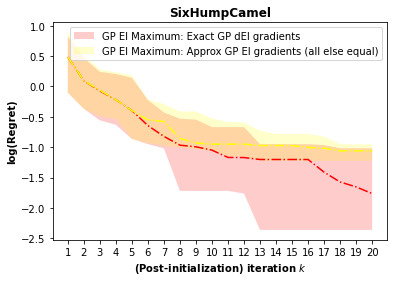

In [142]:
### Visualise!

title = func
plt.figure()

plt.plot(median_ExactSimpleRegret_exact, color = 'Red', ls='-.')
plt.plot(median_ApproxSimpleRegret_exact, color = 'Yellow', ls='-.')

xstar = np.arange(0, iters, step=1)
plt.fill_between(xstar, lower_ExactSimpleRegret_exact, upper_ExactSimpleRegret_exact, facecolor = 'Red', alpha=0.2, label='GP EI Maximum: Exact GP dEI gradients')
plt.fill_between(xstar, lower_ApproxSimpleRegret_exact, upper_ApproxSimpleRegret_exact, facecolor = 'Yellow', alpha=0.2, label='GP EI Maximum: Approx GP EI gradients (all else equal)')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualize!